In [3]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from math import isnan
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

In [5]:
# READ IN ECG AND EDA DATA
def dataread(ECGfile,EDAfile,triggerfile):
    # read in the ECG data
    data_ECG = pd.read_csv(ECGfile, sep='\t', names = ['ECG','time','nothing'], engine='python')
    data_ECG = data_ECG.drop(columns=['nothing']) #drop column with no data in it

    
    # set the start time to use to normalize the other times
    normalize_time = data_ECG.iloc[0,1]
    data_ECG.time = data_ECG.time-normalize_time


    # read in EDA data
    data_EDA = pd.read_csv(EDAfile, sep='\t', names = ['EDA','time','nothing'], engine='python')
    # do the same normalization
    data_EDA = data_EDA.drop(columns=['nothing'])
    data_EDA.time = data_EDA.time-normalize_time

    # read in trigger file
    triggers = pd.read_csv(triggerfile, sep='\t', names = ['clip','on','off'], engine='python')
    triggers.on = triggers.on-normalize_time
    triggers.off = triggers.off-normalize_time
    
    
    # Combine the ECG and EDA signals into one dataframe, only keeping data with matching time stamps
    #something is wrong with this
    signals = data_ECG.join(data_EDA.set_index('time'), on='time', how='inner',sort='True').sort_index('index')
    
    # Create the 'triggers' column with all zeros
    signals["triggers"] = np.zeros(len(signals))
    # This checks which time stamps fall into the time ranges when the clips are delivered, results in a column of "true" and "false"
    conditions = pd.concat([(signals['time'] >= triggers.on[i]) & (signals['time'] <= triggers.off[i]) for i in range(0,17)],axis=1).any(axis=1)
    signals["triggers"] = conditions

    return signals

In [6]:
# SIGNAL PROCESSING
# "Neurokit" method uses a Butterworth filter, but this can be changed to use a Pan-Tomkins filter
# ECG uses a 5th order Butterworth filter
# EDA "neurokit" uses a 4th order Butterworth filter
# Documentation can be found here: https://neurokit2.readthedocs.io/en/master/_modules/neurokit2/ecg/ecg_clean.html

# Cleaning function
def cleaning(ECG, EDA, triggers):
    signals['clean_ECG'] = nk.ecg_clean(ECG, sampling_rate=100,method='neurokit')
    signals['clean_EDA'] = nk.eda_clean(EDA, sampling_rate=100, method='neurokit')
    
    # also compute z scores for use in further analysis
    zscores = pd.DataFrame(columns=['ECG','EDA'])
    zscores['ECG'] = nk.standardize(signals['clean_ECG'])
    zscores['EDA'] = nk.standardize(signals['clean_EDA'])
    zscores['triggers'] = triggers
    return zscores


In [7]:
# EVENT MARKING
def events(signals):
    # The clip segments can be used to section off the signals and they can be processed from there 
    #condition_list = ["CLIP1", "CLIP2", "CLIP3","CLIP4","CLIP5","CLIP6","CLIP7","CLIP8","CLIP9",
                #  "CLIP10","CLIP11","CLIP12","CLIP13","CLIP14","CLIP15","CLIP16", "CLIP17"]
    eventlist = nk.events_find(event_channel=signals.triggers,
                        threshold_keep='above')
                        #event_conditions=condition_list)
   
    # get rid of markers with durations less than 10 seconds
    events_df = pd.DataFrame.from_dict(eventlist,orient='columns')
    events_df = events_df[events_df.duration != 1]
    eventlist_new = events_df.to_dict('series')
    eventlist_new = {key:val.to_numpy() for key,val in eventlist_new.items()}

    # the following calculations create an 'offset' and 'recovery' value based on the clip delivery times
    eventlist_new['offset'] = eventlist_new['onset'] + eventlist_new['duration']
    eventlist_new['recovery'] = [eventlist_new['onset'][i+1] - eventlist_new['offset'][i] for i in range(len(eventlist_new['offset'])-1)]
    
    # Establish here which part of the signal is the baseline for getting difference scores between the clips and rests and the baseline
    norm_end = eventlist['onset'][1]
    difference_data = signals[signals.index < norm_end]
    
    # Create epochs based on the trigger times
    epochs_vid_on = nk.epochs_create(signals, eventlist_new['onset'], sampling_rate=100, epochs_start=0,epochs_end=10)
    epochs_vid_off = nk.epochs_create(signals, eventlist_new['offset'], sampling_rate=100, epochs_start=0,epochs_end=10)
    
    # Then convert the epochs to dfs to parse the data for feature extraction
    chunks_on = nk.epochs_to_df(epochs_vid_on)
    chunks_off = nk.epochs_to_df(epochs_vid_off)

    return chunks_on, chunks_off, difference_data

In [8]:
# DETECT PEAKS WITH PEAK METHOD (ORIGINAL)
def ECGpeak_detect(ECG,samplerate):
    # peak detection
    #Extract R peaks locations
    # _,rpeaks = nk.ecg_peaks(ECG,sampling_rate=samplerate,method='neurokit')
    ECG.reset_index(drop=True,inplace=True)
    # info contains the sample stamp for each R peak
    info = nk.ecg_findpeaks(ECG, sampling_rate=samplerate, method="neurokit")
    #plot = nk.events_plot(info["ECG_R_Peaks"][:3], ECG_signal[0:200])
    
# feature extraction: extract 52 different features based on the time differences between each peak
# don't have anything yet with intervals between the smaller peaks and the R peak
    if len(info) > 0:
        # Identify the smaller parts of the waveform; "show" command produces plot of each waveform on top of the others
        # waves_peak contains the sample stamp for the smaller parts of the waveform
        _, waves_peak = nk.ecg_delineate(ECG, sampling_rate=100,show=False) #show_type='peaks')
        plot = nk.events_plot([info['ECG_R_Peaks'],
        waves_peak['ECG_P_Peaks'],
        waves_peak['ECG_Q_Peaks'],
        waves_peak['ECG_S_Peaks'],
        waves_peak['ECG_T_Peaks']],ECG_on)
        Rpeak_feats = nk.hrv(info['ECG_R_Peaks'],samplerate).dropna(axis=1)
        
        # This extracts only the time features
        #Rpeak_feats = nk.hrv_time(info['ECG_R_Peaks'],samplerate, show=True)
        
        # This extracts the nonlinear features derived from analysis of the Poincare plot
        # Start without this and then add in if wanted
        # nonlinear_feats = nk.hrv_nonlinear(info['ECG_R_Peaks'],samplerate,show=True)
        
    else:
        info = float("NaN")
        print('Could not detect R peaks')

    if len(waves_peak['ECG_P_Peaks']) > 2:
        Ppeak_feats = nk.hrv(waves_peak['ECG_P_Peaks'],samplerate)
    else: 
        Ppeak_feats = float("NaN")
        print('Could not detect P peaks')
    if len(waves_peak['ECG_Q_Peaks']) > 2:
        Qpeak_feats = nk.hrv(waves_peak['ECG_Q_Peaks'],samplerate)
    else:
        Qpeak_feats = float("NaN")
        print('Could not detect Q peaks')
    if len(waves_peak['ECG_S_Peaks']) > 2:
        Speak_feats = nk.hrv(waves_peak['ECG_S_Peaks'],samplerate)
    else: 
        Speak_feats = float("NaN")
        print('Could not detect S peaks')
    if len(waves_peak['ECG_T_Peaks']) > 2:
        Tpeak_feats = nk.hrv(waves_peak['ECG_T_Peaks'],samplerate)
    else: 
        Tpeak_feats = float("NaN")
        print('Could not detect T peaks')

                
            # Plot the P, Q, T, and S waves
            # plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:6],
            #                       waves_peak['ECG_P_Peaks'][:6],
            #                       waves_peak['ECG_Q_Peaks'][:6],
            #                       waves_peak['ECG_S_Peaks'][:6]], ECG_signal[:425])
    

    return info, waves_peak, Rpeak_feats, Ppeak_feats, Qpeak_feats, Speak_feats, Tpeak_feats


In [10]:
# DETECT PEAKS WITH PEAK METHOD (NEW)
def ECGpeak_detect_new(ECG,samplerate):
# This function first detects the R peaks, then uses their locations to detect the smaller parts of the waveform.
# Features extracted from the ECG signal are only in the time domain in this function due to the short sample duration

    # Reset the index of the ECG signal to start from zero, avoid alignment issues
    ECG.reset_index(drop=True,inplace=True)

    # info contains the sample stamp for each R peak
    info = nk.ecg_findpeaks(ECG, sampling_rate=samplerate, method="neurokit")

    # if the function is able to find the R peaks, we can extract the smaller parts of the waveform
    if len(info) > 0:
        # Identify the smaller parts of the waveform; "show" command produces plot of each waveform on top of the others
        # waves_peak contains the sample stamp for the smaller parts of the waveform
        _, waves_peak = nk.ecg_delineate(ECG, sampling_rate=100,show=False) #show_type='peaks')

        # This extracts only the time features based on the R peaks
        Rpeak_feats = nk.hrv_time(info['ECG_R_Peaks'],samplerate, show=False)

        # This extracts the nonlinear features derived from analysis of the Poincare plot
        # Start without this and then add in if wanted
        # nonlinear_feats = nk.hrv_nonlinear(info['ECG_R_Peaks'],samplerate,show=True)

    else:
        info = float("NaN")
        print('Could not detect R peaks')

    
    # This section calculates intervals between different parts of the waveform
    if len(waves_peak['ECG_P_Peaks']) > 0:
        
        # Calculate P-R intervals
        rpeaks = info['ECG_R_Peaks']
        rpeaks = rpeaks[~np.isnan(rpeaks)]
        ppeaks = waves_peak['ECG_P_Peaks']
        #ppeaks = ppeaks[~np.isnan(ppeaks)]
        tpeaks = np.array(waves_peak['ECG_T_Peaks'])
        #tpeaks = tpeaks[~np.isnan(tpeaks)]
        speaks = np.array(waves_peak['ECG_S_Peaks'])
        #speaks = speaks[~np.isnan(speaks)]

        if len(ppeaks) == len(rpeaks):
            PR_ints = rpeaks - ppeaks
        else: 
            if len(rpeaks) > len(ppeaks):
                PR_ints = rpeaks[0:len(ppeaks)] - ppeaks
            else:
                print('more R than P peaks')
                if len(rpeaks) < len(ppeaks):
                    PR_ints = rpeaks - ppeaks[0:len(rpeaks)]
                    print(PR_ints)
                else:
                    print('more P than R peaks') 
        PR_ints_ms = PR_ints/100
        mean_PR = np.mean(PR_ints_ms)
        sd_PR = np.std(PR_ints_ms)

        #####
    #     if len(rpeaks) == len(ppeaks):
    #         PR_ints = rpeaks - ppeaks
    #         PR_ints_ms = PR_ints/100
    #         mean_PR = np.mean(PR_ints_ms)
    #         sd_PR = np.std(PR_ints_ms)
    #     else:
    #         if len(rpeaks) > len(ppeaks):
    #             PR_ints = rpeaks[0:len(ppeaks)] - ppeaks
    #             PR_ints_ms = PR_ints/100
    #             mean_PR = np.mean(PR_ints_ms)
    #             sd_PR = np.std(PR_ints_ms)
    #         else:
    #             print('more P than R peaks')
    #             if len(tpeaks) < len(speaks):
    #                 PR_ints = rpeaks - ppeaks[0:len(rpeaks)]
    #                 PR_ints_ms = PR_ints/100
    #                 mean_PR = np.mean(PR_ints_ms)
    #                 sd_PR = np.std(PR_ints_ms)
    #             else:
    #                 print('more R than P peaks') 


        # Calculate S-T intervals
        tpeaks = np.array(waves_peak['ECG_T_Peaks'])
        #tpeaks = tpeaks[~np.isnan(tpeaks)]

        speaks = np.array(waves_peak['ECG_S_Peaks'])
        #speaks = speaks[~np.isnan(speaks)]

        if len(tpeaks) == len(speaks):
            ST_ints = tpeaks - speaks
        else: 
            if len(tpeaks) > len(speaks):
                ST_ints = tpeaks[0:len(speaks)] - speaks
            else:
                print('more S than T peaks')
                if len(tpeaks) < len(speaks):
                    ST_ints = tpeaks - speaks[0:len(tpeaks)]
                    print(ST_ints)
                else:
                    print('more T than S peaks') 
        ST_ints_ms = ST_ints/100
        mean_ST = np.mean(ST_ints_ms)
        sd_ST = np.std(ST_ints_ms)

        # Calculate P-T intervals
        if len(ppeaks) == len(tpeaks):
            PT_ints = tpeaks - ppeaks
        else: 
            if len(ppeaks) > len(tpeaks):
                PT_ints = tpeaks - ppeaks[0:len(tpeaks)]
            else:
                print('more P than T peaks')
                if len(ppeaks) < len(tpeaks):
                    PT_ints = tpeaks[0:len(ppeaks)] - ppeaks
                    print(PT_ints)
                else:
                    print('more T than P peaks') 
        PT_ints_ms = PT_ints/100
        mean_PT = np.mean(PT_ints_ms)
        sd_PT = np.std(PT_ints_ms)

        # Calculate R-S intervals
        if len(rpeaks) == len(speaks):
            RS_ints = speaks - rpeaks
        else: 
            if len(rpeaks) > len(speaks):
                RS_ints = speaks - rpeaks[0:len(speaks)]
            else:
                print('more R than S peaks')
                if len(rpeaks) < len(speaks):
                    RS_ints = speaks[0:len(rpeaks)] - rpeaks
                    print(RS_ints)
                else:
                    print('more S than R peaks') 
        RS_ints_ms = RS_ints/100
        mean_RS = np.mean(RS_ints_ms)
        sd_RS = np.std(RS_ints_ms)

        # Calculate R-T intervals
        if len(rpeaks) == len(tpeaks):
            RT_ints = tpeaks - rpeaks
        else: 
            if len(rpeaks) > len(tpeaks):
                RT_ints = tpeaks - rpeaks[0:len(tpeaks)]
            else:
                print('more R than T peaks')
                if len(rpeaks) < len(tpeaks):
                    RT_ints = tpeaks[0:len(rpeaks)] - rpeaks
                    print(RT_ints)
                else:
                    print('more T than R peaks') 
        RT_ints_ms = RT_ints/100
        mean_RT = np.mean(RT_ints_ms)
        sd_RT = np.std(RT_ints_ms)

        # Calculate P-S intervals
        if len(ppeaks) == len(speaks):
            PS_ints = speaks - ppeaks
        else: 
            if len(ppeaks) > len(speaks):
                PS_ints = speaks - ppeaks[0:len(speaks)]
            else:
                print('more P than S peaks')
                if len(ppeaks) < len(speaks):
                    PS_ints = speaks[0:len(ppeaks)] - ppeaks
                    print(PS_ints)
                else:
                    print('more S than P peaks') 
        PS_ints_ms = PS_ints/100
        mean_PS = np.mean(PS_ints_ms)
        sd_PS = np.std(PS_ints_ms)

    small_feats = [mean_PR, sd_PR, mean_ST, sd_ST, mean_PT, sd_PT, mean_RS, sd_RS, mean_RT, sd_RT, mean_PS, sd_PS]
    small_feats_df = pd.DataFrame([small_feats],columns=['PR_mean','PR_sd','ST_mean','ST_sd','PT_mean','PT_sd','RS_mean','RS_sd','RT_mean','RT_sd','PS_mean','PS_sd'])

    return info, waves_peak, Rpeak_feats, small_feats_df


In [11]:
# EDA feature extraction function
def EDAfeature_detect(EDA,samplerate):
    # peak detection
    features, info = nk.eda_process(EDA, sampling_rate=samplerate)
   # plt.rcParams['figure.figsize'] = [15, 15]  # Bigger images
   # fig = nk.eda_plot(features[0:10000])
    
    # feature extraction
    # Tonic EDA features: Calculate mean and sd of the tonic EDA
    SCLmean = features['EDA_Tonic'].mean()
    SCLsd = features['EDA_Tonic'].std()
    
    # Phasic EDA features:
    SCRmean = features['EDA_Phasic'].mean()
    SCRsd = features['EDA_Phasic'].std()
    numSCRpeaks = features['SCR_Peaks'].sum()
    meanHeight = features['SCR_Height'].mean()
    meanAmplitude = features['SCR_Amplitude'].mean()
    meanRisetime = features['SCR_RiseTime'].mean()
    meanRecovtime = features['SCR_RecoveryTime'].mean()
    
    # Put everything into one list
    extracted_set = [SCLmean, SCLsd, SCRmean, SCRsd, numSCRpeaks, meanHeight, meanAmplitude, meanRisetime, meanRecovtime]
    extracted = pd.DataFrame([extracted_set],columns=['SCLmean','SCLsd','SCRmean','SCRsd','numSCRpeaks','meanHeight','meanAmplitude','meanRisetime','meanRecovtime'])
    
    return features, info, extracted


In [12]:
# FULL PROCEDURE (before ML) # This cell takes a long time to run
# read in data
# This is the list of all subject file folders in the directory = 'spider_fear/files/VP02'
subs = ['VP02', 'VP03','VP05','VP06','VP08','VP09','VP11','VP12','VP14','VP15','VP17','VP18','VP20','VP23','VP24','VP26','VP27',
        'VP29','VP30','VP32','VP33','VP35','VP36','VP38','VP39','VP41','VP42','VP44','VP45','VP47','VP48','VP50','VP51','VP53',
        'VP54','VP56','VP57','VP59','VP61','VP62','VP63','VP64','VP65','VP66','VP68','VP69','VP70','VP71','VP72','VP73','VP74',
        'VP75','VP76','VP77','VP78','VP79','VP80']

# loop through the files for each subject
chunks_on_dict = {}
chunks_off_dict = {}
diffs_dict = {}
zscores_dict = {}
for i in subs:
    ECGfile = 'spider_fear/files/%s/BitalinoECG.txt' % (i)
    EDAfile = 'spider_fear/files/%s/BitalinoGSR.txt' % (i)
    triggerfile = 'spider_fear/files/%s/Triggers.txt' % (i)
    signals = dataread(ECGfile,EDAfile,triggerfile)
    
    # clean the data and convert to z-scores 
    z_scores = cleaning(signals['ECG'],signals['EDA'],signals['triggers'])
    # Run event marking function to split data into epochs
    ch_on, ch_off, diff = events(z_scores)
    
    # Create a name for each subject's data frame
    zscores_var = 'zscores_%s' % (i)
    chunks_on_var = 'chunks_on_%s' % (i)
    chunks_off_var = 'chunks_off_%s' % (i)
    diff_data_var = 'difference_data_%s' % (i)
    
    # store all the data in dictionaries
    chunks_on_dict[i] = ch_on
    chunks_off_dict[i] = ch_off
    diffs_dict[i] = diff
    zscores_dict[i] = z_scores


# Plot the clean signals vs. the raw signals
#fig, ax = plt.subplots(1)
#ax = signals['ECG'].plot(y='ECG') 
#ax = signals['clean_ECG'].plot(y='clean_ECG')
#ax.set_xlim(0,600)
#ax.set_xlabel('samples (at 100 Hz)')
#ax.set_ylabel('voltage (mV)')
#ax.legend()

#fig, ax = plt.subplots(1)
#ax = signals['EDA'].plot(y='EDA') 
#ax = signals['clean_EDA'].plot(y='clean_EDA')
#ax.set_xlim(0,50000)
#ax.set_xlabel('samples (at 100 Hz)')
#ax.set_ylabel('skin conductance (\u03BC Siemens)')
#ax.legend()

# Event marking and sectioning data based on events.  "Label" column shows which section of data
#chunks_on, chunks_off, difference_data = events(zscores)


In [13]:
# Don't need to re-run the data cleaning etc. every time, so split this out
# subs = ['VP02', 'VP03','VP05','VP06','VP08','VP09','VP11','VP12','VP14','VP15','VP17','VP18','VP20','VP23','VP24','VP26','VP27',
#         'VP29','VP30','VP32','VP33','VP35','VP36','VP38','VP39','VP41','VP42','VP44','VP45','VP47','VP48','VP50','VP51','VP53',
#         'VP54','VP56','VP57','VP59','VP61','VP62','VP63','VP64','VP65','VP66','VP68','VP69','VP70','VP71','VP72','VP73','VP74',
#         'VP75','VP76','VP77','VP78','VP79','VP80']
#Without VP70 because of noise
subs = ['VP02', 'VP03','VP05','VP06','VP08','VP09','VP11','VP12','VP14','VP15','VP17','VP18','VP20','VP23','VP24','VP26','VP27',
        'VP29','VP30','VP32','VP33','VP35','VP36','VP38','VP39','VP41','VP42','VP44','VP45','VP47','VP48','VP50','VP51','VP53',
        'VP54','VP56','VP57','VP59','VP61','VP62','VP63','VP64','VP65','VP66','VP68','VP69','VP71','VP72','VP73','VP74',
        'VP75','VP76','VP77','VP78','VP79','VP80']

# set the sampling rate
sampling = 100

# set up empty dictionaries to store features.  One for features without smaller peaks, one for features with smaller peaks, and
# one for normalization features
features_trad = pd.DataFrame()
features_novel = pd.DataFrame()
features_norm = pd.DataFrame()
for i in subs:
    # data_on is the data frame of data with the video clip on
    data_on = chunks_on_dict[i]
    
    # data_off is the data frame of data with the video clips off
    data_off = chunks_off_dict[i]
    
    # data_diff is the data frame of data for normalization
    data_diff = diffs_dict[i]
    
    # select 10 seconds from the normalization data
    ECG_norm = data_diff['ECG'].iloc[1000:2000]
    EDA_norm = data_diff['EDA'].iloc[1000:2000]
    
    # Compute the norm features
    # info_norm, waves_peak_norm, Rpeak_feats_norm, Ppeak_feats_norm, Qpeak_feats_norm, Speak_feats_norm, Tpeak_feats_norm = ECGpeak_detect(ECG_norm,sampling)
    #info_norm, waves_peak_norm, Rpeak_feats_norm, Ppeak_feats_norm, Qpeak_feats_norm, Speak_feats_norm = ECGpeak_detect(ECG_norm,sampling)
    info_norm, waves_peak_norm, Rpeak_feats_norm, small_feats_norm = ECGpeak_detect_new(ECG_norm,sampling)
    #info_norm, waves_peak_norm, Rpeak_feats_norm, Ppeak_feats_norm, Qpeak_feats_norm = ECGpeak_detect(ECG_norm,sampling)
    display(type(Rpeak_feats_norm))
    _, info_norm, extracted_set_norm = EDAfeature_detect(EDA_norm, sampling)
    feats_norm = pd.concat([Rpeak_feats_norm, small_feats_norm, extracted_set_norm],axis=1)
    features_norm = features_norm.append(feats_norm)
    
    for j in range(1,17):
        print(i,j)
        data_part_on = data_on[data_on['Label'] == str(j)]
        ECG_on = data_part_on['ECG'].iloc[0:1000]
        EDA_on = data_part_on['EDA'].iloc[0:1000]
        
        data_part_off = data_off[data_off['Label'] == str(j)]
        ECG_off = data_part_off['ECG'].iloc[0:1000]
        EDA_off = data_part_off['EDA'].iloc[0:1000]
        
        
        #info_on, waves_peak_on, Rpeak_feats_on = ECGpeak_detect(ECG_on,sampling)
        #info_on, waves_peak_on, Rpeak_feats_on, Ppeak_feats_on, Qpeak_feats_on = ECGpeak_detect(ECG_on,sampling)
        #info_on, waves_peak_on, Rpeak_feats_on, Ppeak_feats_on, Qpeak_feats_on, Speak_feats_on = ECGpeak_detect(ECG_on,sampling)
        
        info_on, waves_peak_on, Rpeak_feats_on, small_feats_on = ECGpeak_detect_new(ECG_on,sampling)
        
        
        #info_off, waves_peak_off, Rpeak_feats_off = ECGpeak_detect(ECG_off,sampling)
        #info_off, waves_peak_off, Rpeak_feats_off, Ppeak_feats_off, Qpeak_feats_off = ECGpeak_detect(ECG_off,sampling)
        #info_off, waves_peak_off, Rpeak_feats_off, Ppeak_feats_off, Qpeak_feats_off, Speak_feats_off = ECGpeak_detect(ECG_off,sampling)
        info_off, waves_peak_off, Rpeak_feats_off, small_feats_off = ECGpeak_detect_new(ECG_off,sampling)
        # need to save all the features in a data frame with a column saying video "on" or "off" and a column with sub number and clip number
        #Rpeaks_off = Rpeak_feats_off.values.tolist()
        #Ppeaks_off = Ppeak_feats_off.values.tolist()
        #Qpeaks_off = Qpeak_feats_off.values.tolist()
        #Speaks_off = Speak_feats_off.values.tolist()
        #Tpeaks_off = Tpeak_feats_off.values.tolist()
        
        # Extract EDA features
        features_on, info_on, extracted_set_on = EDAfeature_detect(EDA_on, sampling)
        features_off, info_off, extracted_set_off = EDAfeature_detect(EDA_off, sampling)
        
        # Add features into dictionaries
        # ADD IN TAGGING WITH VIDEO ON OR OFF
        feats_trad = pd.concat([Rpeak_feats_on, extracted_set_on],axis=1)
        feats_trad['stress'] = 1
        features_trad = features_trad.append(feats_trad)
        feats_novel = pd.concat([Rpeak_feats_on, small_feats_on, extracted_set_on],axis=1)
        feats_novel['stress'] = 1
        features_novel = features_novel.append(feats_novel)
        
        feats_trad_2 = pd.concat([Rpeak_feats_off, extracted_set_off],axis=1)
        feats_trad_2['stress'] = 0
        features_trad = features_trad.append(feats_trad_2)
        feats_novel_2 = pd.concat([Rpeak_feats_off, small_feats_off, extracted_set_off],axis=1) 
        feats_novel_2['stress'] = 0
        features_novel = features_novel.append(feats_novel_2)
    




# Extract EDA features
#features, info, extracted_set = EDAfeature_detect(EDA_signal, sampling)

# list of features from ECG and EDA (traditional)
#feature_arr_traditional = pd.array([Rpeaks, extracted_set])

# list of features from ECG and EDA (novel)
# feature_arr_novel = pd.array([Rpeaks, Ppeaks, Qpeaks, Speaks, Tpeaks])
# ^this doesn't work, not sure why

# Create data frame to store all the data
#col_titles = [Rpeak_feats.columns, 'SCLmean', 'SCLsd', 'SCRmean', 'SCRsd', 'numSCRpeaks', 'meanHeight', 'meanAmplitude', 
           #   'meanRisetime', 'meanRecovtime']
#sub1_feats = sub1_feats.append(feature_arr_traditional)


# need to set up a dataframe to store the data from each subject, labeled for each subject with an "on" or "off" for video
# Need to take difference between baseline values and clip and non-clip features for each subject

pandas.core.frame.DataFrame

VP02 1
VP02 2
VP02 3
VP02 4
VP02 5
VP02 6


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP02 7
VP02 8
VP02 9
VP02 10
VP02 11
VP02 12
VP02 13


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP02 14
VP02 15
VP02 16


pandas.core.frame.DataFrame

VP03 1
VP03 2
VP03 3
VP03 4
VP03 5
VP03 6
VP03 7


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP03 8
VP03 9
VP03 10
VP03 11
VP03 12
VP03 13
VP03 14
VP03 15
VP03 16


pandas.core.frame.DataFrame

VP05 1
VP05 2
VP05 3
VP05 4


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP05 5
VP05 6
VP05 7
VP05 8
VP05 9
VP05 10
VP05 11
VP05 12


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP05 13
VP05 14
VP05 15
VP05 16


pandas.core.frame.DataFrame

VP06 1
VP06 2
VP06 3
VP06 4
VP06 5
VP06 6
VP06 7
VP06 8
VP06 9
VP06 10
VP06 11
VP06 12
VP06 13
VP06 14
VP06 15
VP06 16


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


pandas.core.frame.DataFrame

VP08 1
VP08 2
VP08 3
VP08 4
VP08 5
VP08 6
VP08 7
VP08 8
VP08 9
VP08 10
VP08 11
VP08 12
VP08 13
VP08 14
VP08 15
VP08 16


pandas.core.frame.DataFrame

VP09 1
VP09 2


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP09 3
VP09 4
VP09 5
VP09 6
VP09 7
VP09 8
VP09 9
VP09 10
VP09 11
VP09 12
VP09 13
VP09 14
VP09 15
VP09 16


pandas.core.frame.DataFrame

VP11 1
VP11 2
VP11 3
VP11 4
VP11 5
VP11 6
VP11 7
VP11 8
VP11 9
VP11 10
VP11 11
VP11 12
VP11 13
VP11 14
VP11 15
VP11 16


pandas.core.frame.DataFrame

VP12 1
VP12 2
VP12 3
VP12 4
VP12 5
VP12 6
VP12 7
VP12 8
VP12 9
VP12 10
VP12 11
VP12 12
VP12 13
VP12 14


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP12 15
VP12 16


pandas.core.frame.DataFrame

VP14 1
VP14 2
VP14 3
VP14 4
VP14 5
VP14 6
VP14 7
VP14 8
VP14 9
VP14 10
VP14 11
VP14 12
VP14 13
VP14 14
VP14 15
VP14 16


pandas.core.frame.DataFrame

VP15 1
VP15 2
VP15 3
VP15 4
VP15 5
VP15 6
VP15 7
VP15 8
VP15 9
VP15 10
VP15 11
VP15 12
VP15 13
VP15 14
VP15 15
VP15 16


pandas.core.frame.DataFrame

VP17 1
VP17 2
VP17 3
VP17 4
VP17 5
VP17 6
VP17 7
VP17 8
VP17 9
VP17 10
VP17 11
VP17 12
VP17 13
VP17 14
VP17 15
VP17 16


pandas.core.frame.DataFrame

VP18 1
VP18 2
VP18 3
VP18 4
VP18 5
VP18 6
VP18 7
VP18 8
VP18 9
VP18 10
VP18 11
VP18 12


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP18 13
VP18 14
VP18 15
VP18 16


pandas.core.frame.DataFrame

VP20 1
VP20 2
VP20 3
VP20 4
VP20 5
VP20 6
VP20 7
VP20 8
VP20 9
VP20 10
VP20 11
VP20 12
VP20 13
VP20 14
VP20 15
VP20 16


pandas.core.frame.DataFrame

VP23 1
VP23 2
VP23 3
VP23 4
VP23 5
VP23 6
VP23 7
VP23 8
VP23 9
VP23 10
VP23 11
VP23 12
VP23 13
VP23 14
VP23 15
VP23 16


pandas.core.frame.DataFrame

VP24 1
VP24 2
VP24 3
VP24 4
VP24 5
VP24 6
VP24 7
VP24 8
VP24 9
VP24 10
VP24 11
VP24 12
VP24 13
VP24 14
VP24 15
VP24 16


pandas.core.frame.DataFrame

VP26 1
VP26 2
VP26 3
VP26 4
VP26 5
VP26 6
VP26 7
VP26 8
VP26 9
VP26 10
VP26 11
VP26 12
VP26 13
VP26 14
VP26 15
VP26 16


pandas.core.frame.DataFrame

VP27 1
VP27 2
VP27 3
VP27 4
VP27 5
VP27 6
VP27 7
VP27 8
VP27 9
VP27 10
VP27 11
VP27 12
VP27 13
VP27 14
VP27 15
VP27 16


pandas.core.frame.DataFrame

VP29 1
VP29 2
VP29 3
VP29 4
VP29 5
VP29 6
VP29 7
VP29 8
VP29 9
VP29 10


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP29 11


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP29 12


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP29 13
VP29 14


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP29 15
VP29 16


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


pandas.core.frame.DataFrame

VP30 1
VP30 2
VP30 3
VP30 4
VP30 5
VP30 6
VP30 7
VP30 8
VP30 9
VP30 10
VP30 11
VP30 12
VP30 13
VP30 14


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP30 15
VP30 16


pandas.core.frame.DataFrame

VP32 1
VP32 2
VP32 3
VP32 4
VP32 5
VP32 6
VP32 7
VP32 8
VP32 9
VP32 10
VP32 11
VP32 12
VP32 13
VP32 14
VP32 15
VP32 16


pandas.core.frame.DataFrame

VP33 1
VP33 2
VP33 3
VP33 4
VP33 5
VP33 6
VP33 7
VP33 8
VP33 9
VP33 10
VP33 11
VP33 12
VP33 13
VP33 14
VP33 15
VP33 16


pandas.core.frame.DataFrame

VP35 1


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP35 2
VP35 3
VP35 4
VP35 5
VP35 6


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP35 7
VP35 8
VP35 9


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP35 10
VP35 11
VP35 12
VP35 13
VP35 14
VP35 15
VP35 16


pandas.core.frame.DataFrame

VP36 1
VP36 2
VP36 3
VP36 4
VP36 5
VP36 6
VP36 7
VP36 8
VP36 9
VP36 10
VP36 11
VP36 12


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP36 13


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP36 14
VP36 15
VP36 16


pandas.core.frame.DataFrame

VP38 1
VP38 2


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP38 3
VP38 4
VP38 5
VP38 6
VP38 7
VP38 8
VP38 9
VP38 10
VP38 11
VP38 12
VP38 13
VP38 14
VP38 15
VP38 16


pandas.core.frame.DataFrame

VP39 1
VP39 2
VP39 3
VP39 4
VP39 5
VP39 6
VP39 7
VP39 8
VP39 9
VP39 10
VP39 11
VP39 12
VP39 13
VP39 14
VP39 15
VP39 16


pandas.core.frame.DataFrame

VP41 1
VP41 2
VP41 3
VP41 4
VP41 5
VP41 6
VP41 7
VP41 8
VP41 9
VP41 10
VP41 11
VP41 12
VP41 13
VP41 14
VP41 15
VP41 16


pandas.core.frame.DataFrame

VP42 1
VP42 2
VP42 3
VP42 4
VP42 5
VP42 6
VP42 7
VP42 8
VP42 9
VP42 10
VP42 11
VP42 12
VP42 13
VP42 14
VP42 15
VP42 16


pandas.core.frame.DataFrame

VP44 1
VP44 2
VP44 3
VP44 4
VP44 5
VP44 6
VP44 7
VP44 8
VP44 9
VP44 10
VP44 11
VP44 12
VP44 13
VP44 14
VP44 15
VP44 16


pandas.core.frame.DataFrame

VP45 1


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP45 2
VP45 3
VP45 4
VP45 5
VP45 6
VP45 7
VP45 8
VP45 9
VP45 10
VP45 11
VP45 12
VP45 13
VP45 14
VP45 15
VP45 16


pandas.core.frame.DataFrame

VP47 1
VP47 2
VP47 3
VP47 4
VP47 5
VP47 6
VP47 7
VP47 8
VP47 9
VP47 10
VP47 11
VP47 12
VP47 13
VP47 14
VP47 15
VP47 16


pandas.core.frame.DataFrame

C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP48 1
VP48 2
VP48 3
VP48 4


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP48 5
VP48 6
VP48 7
VP48 8
VP48 9
VP48 10
VP48 11
VP48 12
VP48 13
VP48 14
VP48 15
VP48 16


pandas.core.frame.DataFrame

VP50 1
VP50 2
VP50 3
VP50 4
VP50 5
VP50 6
VP50 7
VP50 8
VP50 9
VP50 10
VP50 11
VP50 12
VP50 13
VP50 14
VP50 15
VP50 16


pandas.core.frame.DataFrame

VP51 1
VP51 2
VP51 3
VP51 4
VP51 5
VP51 6
VP51 7
VP51 8
VP51 9
VP51 10
VP51 11
VP51 12
VP51 13
VP51 14
VP51 15
VP51 16


pandas.core.frame.DataFrame

VP53 1
VP53 2
VP53 3
VP53 4
VP53 5
VP53 6
VP53 7
VP53 8
VP53 9
VP53 10
VP53 11
VP53 12
VP53 13
VP53 14
VP53 15
VP53 16


pandas.core.frame.DataFrame

VP54 1
VP54 2
VP54 3
VP54 4
VP54 5
VP54 6
VP54 7
VP54 8
VP54 9
VP54 10
VP54 11
VP54 12
VP54 13
VP54 14
VP54 15
VP54 16


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


pandas.core.frame.DataFrame

VP56 1
VP56 2
VP56 3
VP56 4
VP56 5
VP56 6
VP56 7
VP56 8
VP56 9
VP56 10
VP56 11
VP56 12
VP56 13
VP56 14
VP56 15
VP56 16


pandas.core.frame.DataFrame

VP57 1
VP57 2
VP57 3
VP57 4
VP57 5
VP57 6
VP57 7
VP57 8
VP57 9
VP57 10
VP57 11
VP57 12
VP57 13
VP57 14
VP57 15
VP57 16


pandas.core.frame.DataFrame

VP59 1


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP59 2
VP59 3
VP59 4
VP59 5
VP59 6
VP59 7
VP59 8


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP59 9
VP59 10
VP59 11
VP59 12
VP59 13
VP59 14
VP59 15
VP59 16


pandas.core.frame.DataFrame

VP61 1
VP61 2
VP61 3
VP61 4
VP61 5
VP61 6
VP61 7
VP61 8
VP61 9
VP61 10
VP61 11
VP61 12
VP61 13
VP61 14
VP61 15
VP61 16


pandas.core.frame.DataFrame

VP62 1
VP62 2
VP62 3
VP62 4
VP62 5
VP62 6
VP62 7
VP62 8
VP62 9
VP62 10
VP62 11
VP62 12
VP62 13
VP62 14
VP62 15
VP62 16


pandas.core.frame.DataFrame

VP63 1
VP63 2
VP63 3
VP63 4
VP63 5
VP63 6
VP63 7
VP63 8
VP63 9
VP63 10
VP63 11
VP63 12
VP63 13


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP63 14
VP63 15
VP63 16


pandas.core.frame.DataFrame

VP64 1
VP64 2
VP64 3
VP64 4
VP64 5
VP64 6
VP64 7
VP64 8
VP64 9


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP64 10
VP64 11
VP64 12
VP64 13
VP64 14
VP64 15
VP64 16


pandas.core.frame.DataFrame

VP65 1
VP65 2
VP65 3
VP65 4
VP65 5
VP65 6


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP65 7
VP65 8
VP65 9
VP65 10
VP65 11
VP65 12
VP65 13
VP65 14
VP65 15
VP65 16


pandas.core.frame.DataFrame

VP66 1
VP66 2
VP66 3
VP66 4
VP66 5


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP66 6
VP66 7
VP66 8
VP66 9
VP66 10
VP66 11
VP66 12
VP66 13
VP66 14
VP66 15
VP66 16


pandas.core.frame.DataFrame

VP68 1
VP68 2
VP68 3
VP68 4
VP68 5
VP68 6
VP68 7
VP68 8
VP68 9
VP68 10
VP68 11
VP68 12
VP68 13
VP68 14
VP68 15
VP68 16


pandas.core.frame.DataFrame

VP69 1
VP69 2
VP69 3
VP69 4
VP69 5
VP69 6
VP69 7
VP69 8
VP69 9
VP69 10
VP69 11
VP69 12
VP69 13
VP69 14
VP69 15
VP69 16


pandas.core.frame.DataFrame

VP71 1
VP71 2
VP71 3
VP71 4
VP71 5
VP71 6
VP71 7
VP71 8
VP71 9
VP71 10
VP71 11
VP71 12
VP71 13
VP71 14
VP71 15
VP71 16


pandas.core.frame.DataFrame

VP72 1
VP72 2
VP72 3
VP72 4
VP72 5
VP72 6
VP72 7
VP72 8
VP72 9
VP72 10
VP72 11
VP72 12
VP72 13
VP72 14
VP72 15
VP72 16


pandas.core.frame.DataFrame

C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP73 1
VP73 2
VP73 3
VP73 4
VP73 5
VP73 6
VP73 7
VP73 8
VP73 9
VP73 10
VP73 11
VP73 12
VP73 13
VP73 14
VP73 15
VP73 16


pandas.core.frame.DataFrame

VP74 1
VP74 2
VP74 3
VP74 4
VP74 5
VP74 6
VP74 7
VP74 8
VP74 9
VP74 10
VP74 11
VP74 12
VP74 13
VP74 14
VP74 15
VP74 16


pandas.core.frame.DataFrame

VP75 1
VP75 2
VP75 3
VP75 4
VP75 5
VP75 6
VP75 7
VP75 8
VP75 9
VP75 10
VP75 11
VP75 12
VP75 13
VP75 14
VP75 15
VP75 16


pandas.core.frame.DataFrame

VP76 1
VP76 2
VP76 3
VP76 4
VP76 5
VP76 6
VP76 7
VP76 8
VP76 9
VP76 10
VP76 11
VP76 12
VP76 13
VP76 14
VP76 15
VP76 16


pandas.core.frame.DataFrame

VP77 1
VP77 2
VP77 3
VP77 4
VP77 5
VP77 6
VP77 7
VP77 8
VP77 9
VP77 10
VP77 11
VP77 12
VP77 13
VP77 14
VP77 15
VP77 16


pandas.core.frame.DataFrame

VP78 1
VP78 2
VP78 3
VP78 4
VP78 5
VP78 6
VP78 7
VP78 8
VP78 9
VP78 10
VP78 11
VP78 12
VP78 13
VP78 14
VP78 15
VP78 16


pandas.core.frame.DataFrame

C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP79 1
VP79 2
VP79 3
VP79 4
VP79 5
VP79 6
VP79 7
VP79 8
VP79 9
VP79 10
VP79 11
VP79 12
VP79 13
VP79 14
VP79 15
VP79 16


pandas.core.frame.DataFrame

VP80 1
VP80 2
VP80 3
VP80 4
VP80 5
VP80 6
VP80 7
VP80 8
VP80 9
VP80 10
VP80 11
VP80 12
VP80 13


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\eda\eda_peaks.py:114: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])


VP80 14
VP80 15
VP80 16


In [14]:
# Linear Discriminant Analysis (LDA)
import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import plot_roc_curve

# Analysis for traditional data
# Split data into 67% train and 33% test
# reducing the number of samples to the same number used with the extended feature set
feats = features_trad.iloc[:,:]
display(features_trad.shape)
train, test = sklearn.model_selection.train_test_split(feats, test_size=0.33, random_state=0)

# Input is the feature set, output is the true stress classification
features = test.iloc[:,0:23]
stress = test.iloc[:,23]

# Define model
model = LinearDiscriminantAnalysis()

# Define model evaluation method (k-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=None)

#evaluate model
scores = cross_val_score(model, features, stress, scoring='accuracy', cv=cv, n_jobs=-1)

# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# Produce ROC curves
# display(scores)

#vis = plot_roc_curve(model, features, stress)
#fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)


(1792, 24)

Mean Accuracy: 0.904 (0.019)


In [17]:
# Further model assessments
from scipy import stats
from sklearn.metrics import confusion_matrix
# Split data into 67% train and 33% test
feats = features_novel.dropna(axis=0)
display(feats.shape,features_novel.shape)
train, test = sklearn.model_selection.train_test_split(feats, test_size=0.33, random_state=0)

# Input is the feature set, output is the true stress classification
features = test.iloc[:,0:35]
# nov_data = features[['HRV_SDNN', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN','HRV_IQRNN','HRV_pNN50','HRV_pNN20',
#                  'HRV_TINN','PR_mean','PR_sd','ST_mean','ST_sd','PT_mean','PS_sd']].copy()
nov_data = features[['PR_mean','PR_sd','ST_mean','ST_sd','PT_mean','PS_sd']].copy()
trad_data = features[['HRV_RMSSD', 'HRV_MeanNN', 'HRV_CVSD','HRV_MedianNN','HRV_IQRNN','HRV_pNN50','HRV_pNN20',
                  'HRV_TINN','HRV_HTI']].copy()
stress = test.iloc[:,35]


# Define model
model = LinearDiscriminantAnalysis()

# Define model evaluation method (k-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(model, nov_data, stress, scoring='accuracy', cv=cv, n_jobs=-1)
error_score="raise"
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
print(type(stress))
print(stats.pointbiserialr(feats['PS_sd'],feats['stress']))


(960, 36)

(1792, 36)

Mean Accuracy: 0.905 (0.053)
<class 'pandas.core.series.Series'>
PointbiserialrResult(correlation=-0.5186196316859171, pvalue=3.319565903667508e-67)


In [14]:
print(features_novel.columns)

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_pNN50', 'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'PR_mean', 'PR_sd',
       'ST_mean', 'ST_sd', 'PT_mean', 'PT_sd', 'RS_mean', 'RS_sd', 'RT_mean',
       'RT_sd', 'PS_mean', 'PS_sd', 'SCLmean', 'SCLsd', 'SCRmean', 'SCRsd',
       'numSCRpeaks', 'meanHeight', 'meanAmplitude', 'meanRisetime',
       'meanRecovtime', 'stress'],
      dtype='object')


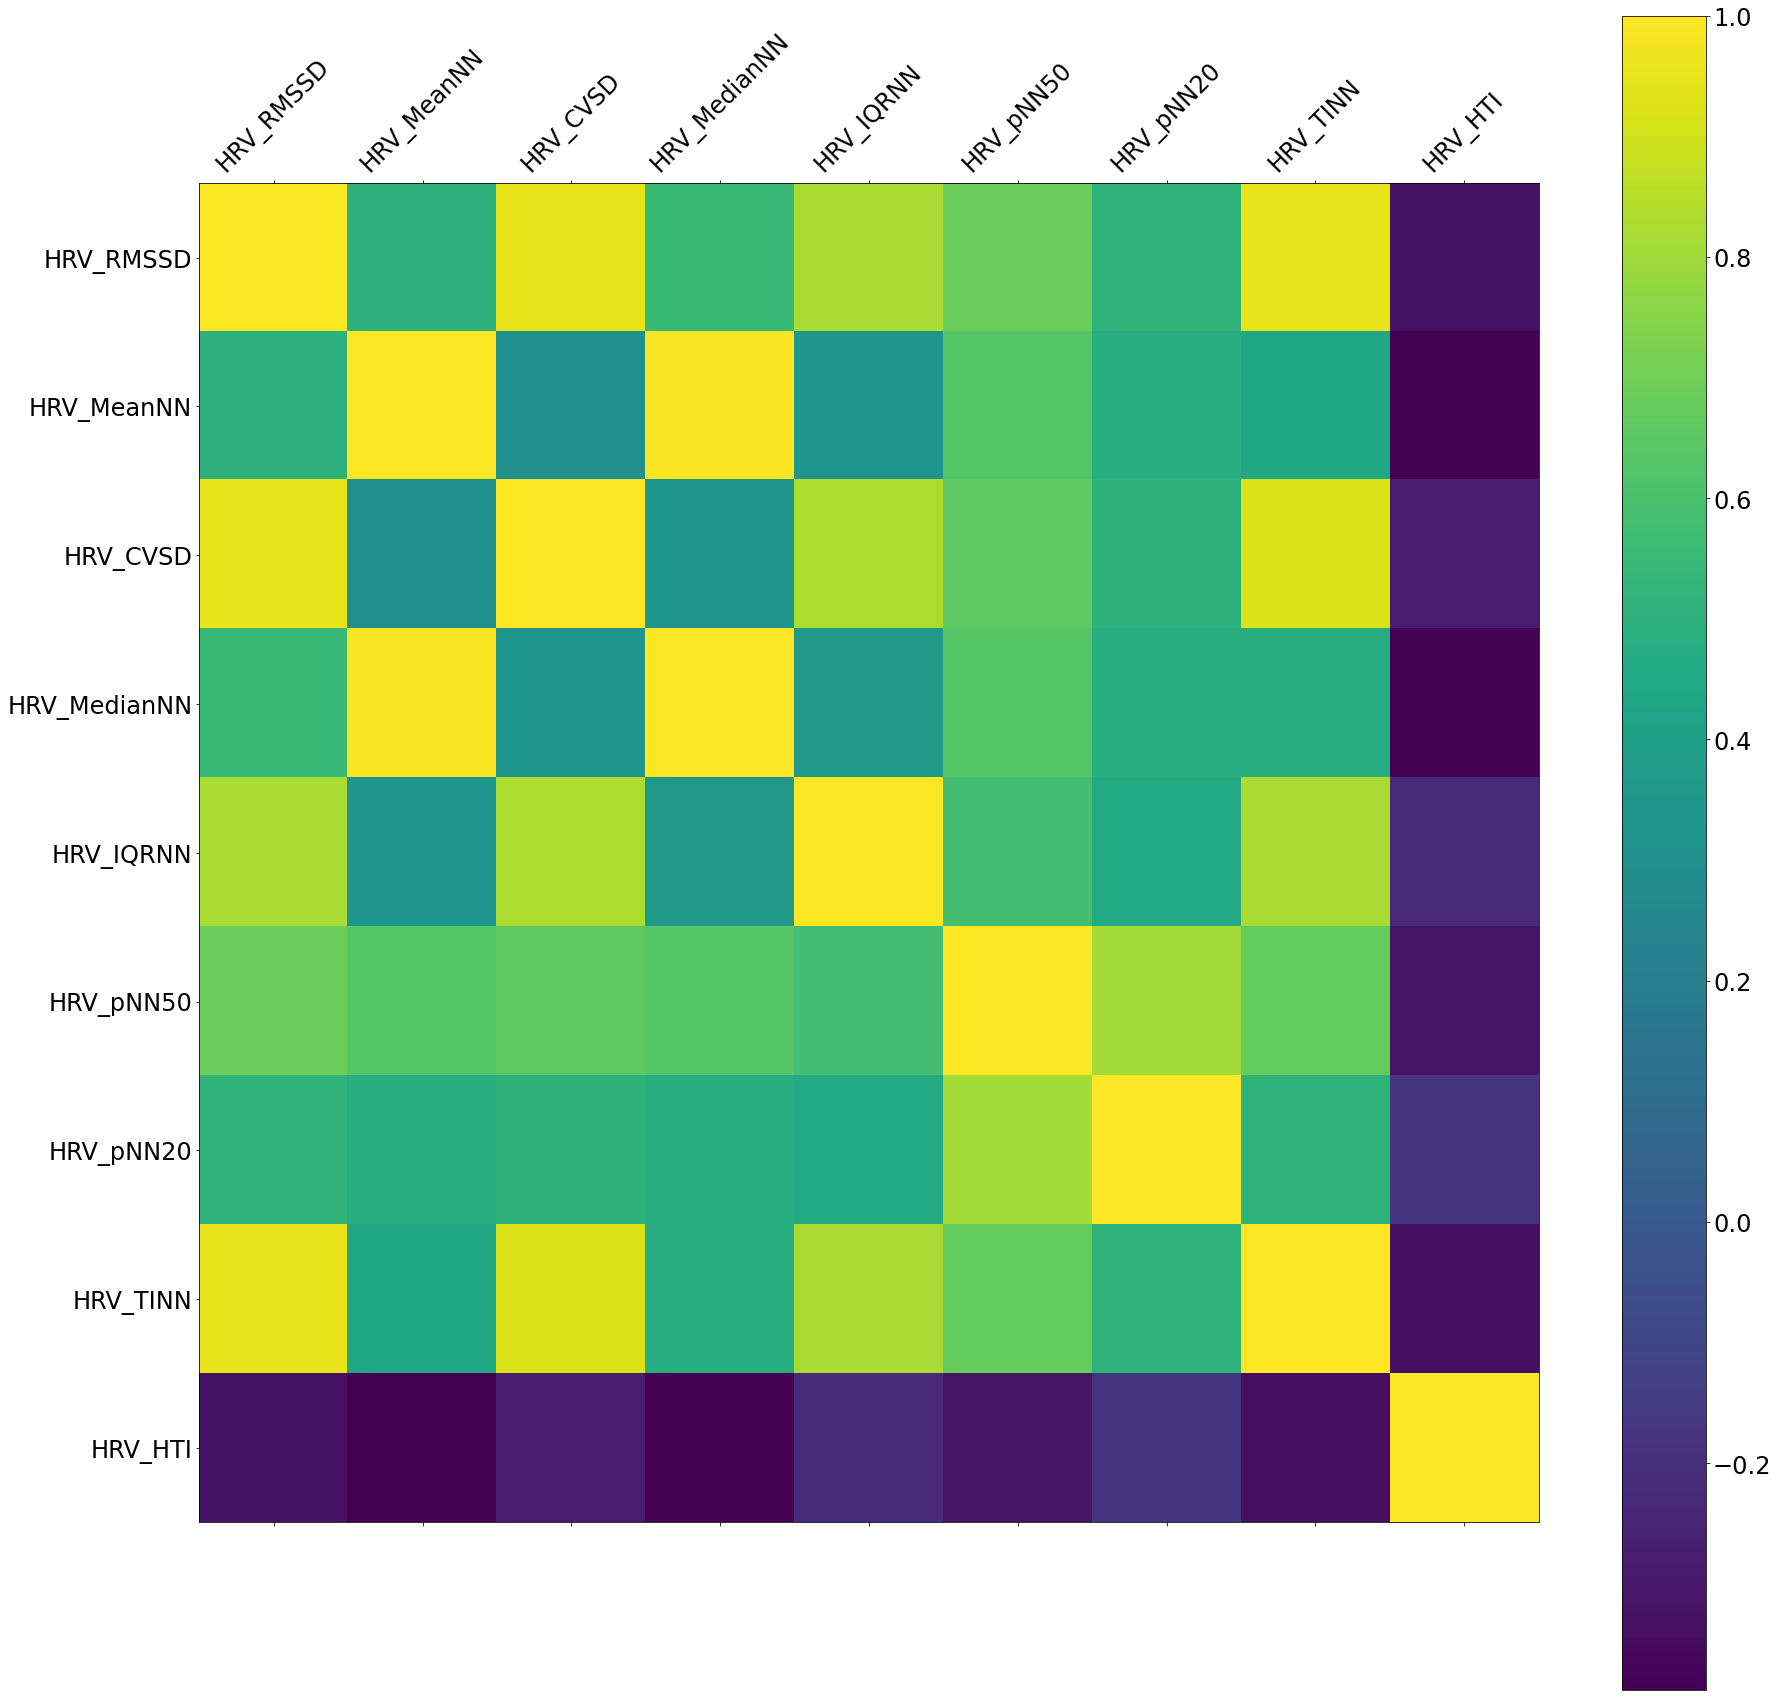

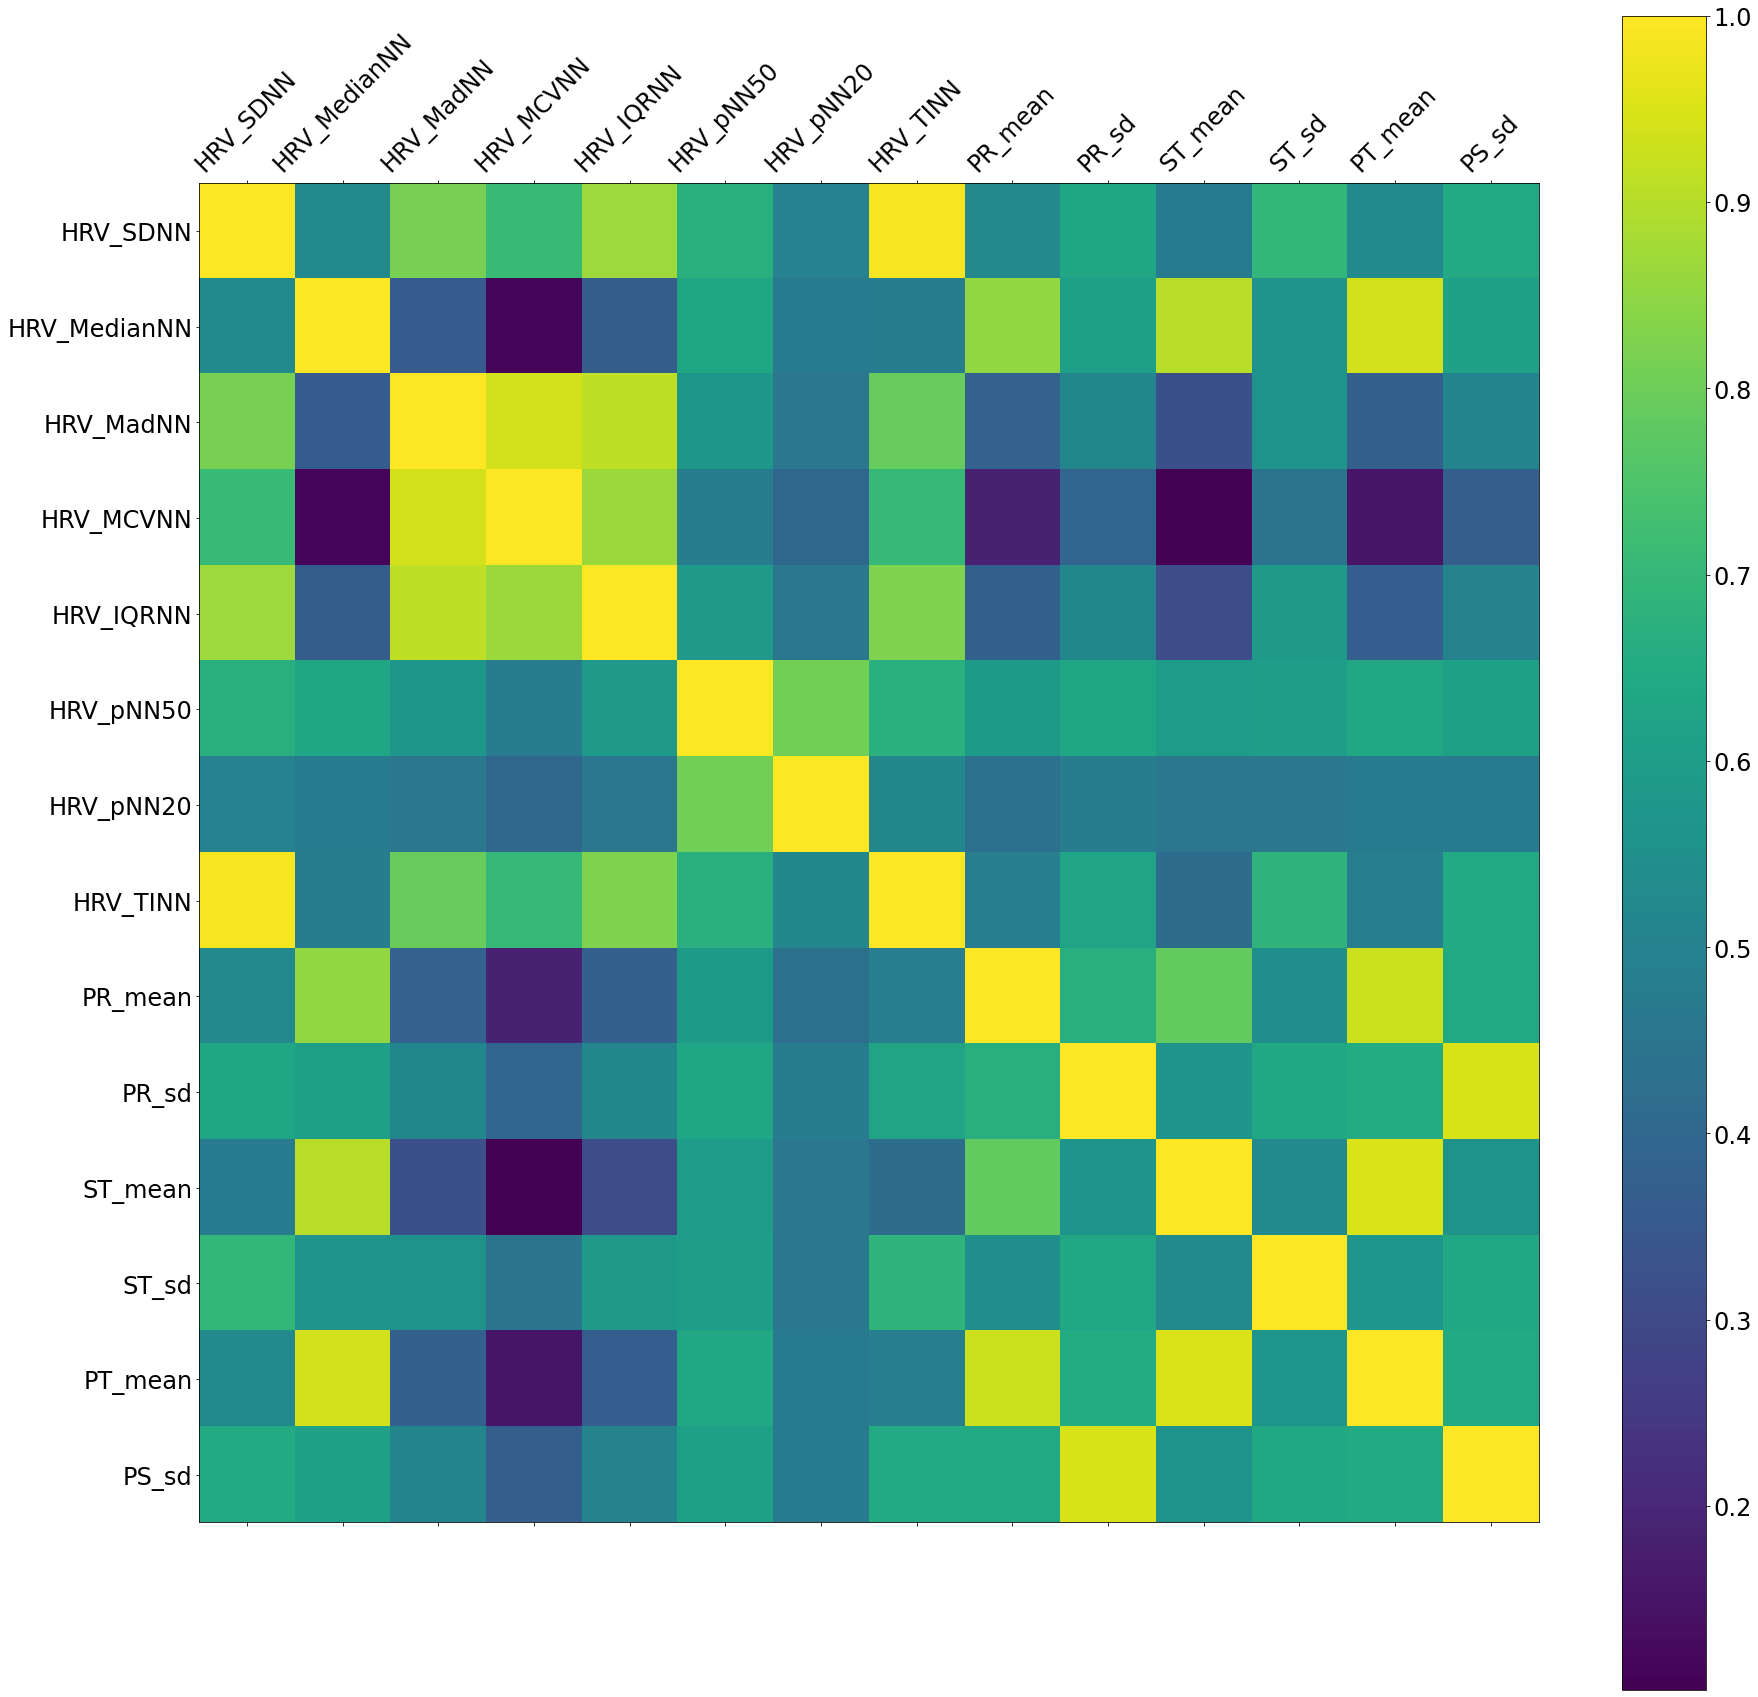

        feature         VIF
0     HRV_RMSSD   54.073635
1    HRV_MeanNN  544.366437
2      HRV_CVSD   43.549490
3  HRV_MedianNN  570.253677
4     HRV_IQRNN    5.919585
5     HRV_pNN50   12.851239
6     HRV_pNN20   25.954431
7      HRV_TINN   23.090624
8       HRV_HTI   11.447860
         feature          VIF
0       HRV_SDNN   223.275747
1   HRV_MedianNN    98.997532
2      HRV_MadNN    32.400270
3      HRV_MCVNN    32.607104
4      HRV_IQRNN    24.434603
5      HRV_pNN50    10.894407
6      HRV_pNN20    22.905698
7       HRV_TINN   179.930045
8        PR_mean   290.530162
9          PR_sd    28.436282
10       ST_mean   476.987435
11         ST_sd     5.180234
12       PT_mean  1553.404219
13         PS_sd    27.033008


In [15]:
# Check for multicollinearity using Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
# feats = features_novel.dropna(axis=0)
# display(feats.shape,features_novel.shape)
# train, test = sklearn.model_selection.train_test_split(feats, test_size=0.33, random_state=0)
# data = train
# vif_data = pd.DataFrame()
# vif_data["feature"] = data.columns

# vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
# print(vif_data)

# fig = plt.figure(figsize=(30,30))
# data = data.drop(['stress'], axis=1)
# plt.matshow(data.corr(method='pearson'),fignum=fig.number)
# plt.xticks(range(data.shape[1]), data.columns, fontsize=18, rotation=45)
# plt.yticks(range(data.shape[1]), data.columns, fontsize=18)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=18)
# plt.show()
data = features_novel.iloc[:,0:28]
data['stress'] = features_novel.iloc[:,27]
data = data.dropna(axis=0)
# correlation matrix for optimized traditional model
trad_data = data[['HRV_RMSSD', 'HRV_MeanNN', 'HRV_CVSD','HRV_MedianNN','HRV_IQRNN','HRV_pNN50','HRV_pNN20',
                  'HRV_TINN','HRV_HTI']].copy()
fig = plt.figure(figsize=(30,30))
plt.matshow(trad_data.corr(method='pearson'),fignum=fig.number)
plt.xticks(range(trad_data.shape[1]), trad_data.columns, fontsize=24, rotation=45)
plt.yticks(range(trad_data.shape[1]), trad_data.columns, fontsize=24)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=24)
plt.show()

# correlation matrix for optimized novel model
nov_data = data[['HRV_SDNN', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN','HRV_IQRNN','HRV_pNN50','HRV_pNN20',
                  'HRV_TINN','PR_mean','PR_sd','ST_mean','ST_sd','PT_mean','PS_sd']].copy()
fig = plt.figure(figsize=(30,30))
plt.matshow(nov_data.corr(method='pearson'),fignum=fig.number)
plt.xticks(range(nov_data.shape[1]), nov_data.columns, fontsize=24, rotation=45)
plt.yticks(range(nov_data.shape[1]), nov_data.columns, fontsize=24)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=24)
plt.show()

# Variance inflation factor for traditional data
trad_vif_data = pd.DataFrame()
trad_vif_data["feature"] = trad_data.columns

trad_vif_data["VIF"] = [variance_inflation_factor(trad_data.values, i) for i in range(len(trad_data.columns))]
print(trad_vif_data)

# Variance inflation factor for novel data
nov_vif_data = pd.DataFrame()
nov_vif_data["feature"] = nov_data.columns

nov_vif_data["VIF"] = [variance_inflation_factor(nov_data.values, i) for i in range(len(nov_data.columns))]
print(nov_vif_data)

(960, 36)

(1792, 36)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    6.1s finished

[2021-02-15 12:46:49] Features: 34/13 -- score: -0.10576923076923077[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    5.7s finished

[2021-02-15 12:46:54] Features: 33/13 -- score: -0.10576923076923077[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    5.3s finished

[2021-02-15 12:47:00] Features: 32/13 -- score: -0.10576923076923077[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)

['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_CVSD', 'HRV_pNN20', 'HRV_HTI', 'PR_mean', 'ST_mean', 'ST_sd', 'PT_mean', 'PS_sd', 'SCLsd', 'meanRecovtime']


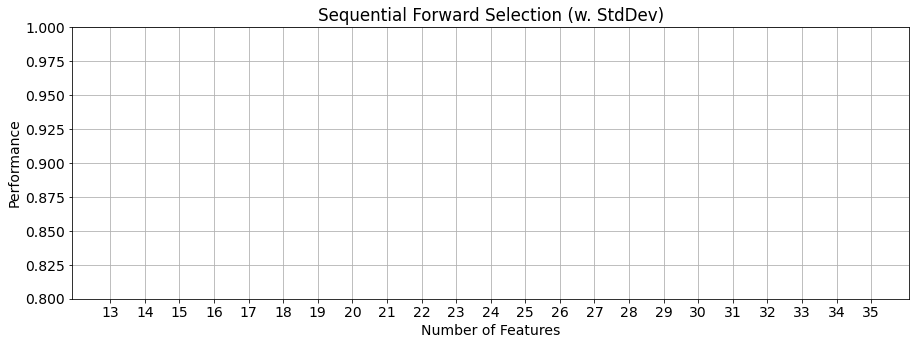

In [16]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Split data into 67% train and 33% test
feats = features_novel.dropna(axis=0)
display(feats.shape,features_novel.shape)
train, test = sklearn.model_selection.train_test_split(feats, test_size=0.33, random_state=0)

# Input is the feature set, output is the true stress classification
features = train.iloc[:,0:35]
stress = train.iloc[:,35]

feature_selector = sfs(LinearDiscriminantAnalysis(),
           k_features=13, 
           forward=False, #can toggle between forward and backward with this bool
           floating=False,
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=10)

features = feature_selector.fit(features, stress)

# Which features?
feat_cols = list(features.k_feature_names_)
print(feat_cols)

fig1 = plot_sfs(features.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [17]:
# LDA with just the ECG features and the novel small-feature intervals
# Looks like the EDA data really isn't adding much
justHRfeats = features_novel.iloc[:,0:18]
justHRfeats['stress'] = features_novel.iloc[:,27]
justHRfeats = justHRfeats.dropna(axis=0)

train, test = sklearn.model_selection.train_test_split(justHRfeats, test_size=0.33, random_state=0)

# Input is the feature set, output is the true stress classification
features = train.iloc[:,0:18]
stress = train.iloc[:,18]


# Define model
model = LinearDiscriminantAnalysis()

# Define model evaluation method (k-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(model, features, stress, scoring='accuracy', cv=cv, n_jobs=-1)
error_score="raise"
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [48]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut

# Split data into 67% train and 33% test
feats = features_novel.dropna(axis=0)
display(feats.shape,features_novel.shape)
train, test = sklearn.model_selection.train_test_split(feats, test_size=0.33, random_state=0)

# Input is the feature set, output is the true stress classification
features = test.iloc[:,0:35]
# nov_data = features[['HRV_SDNN', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN','HRV_IQRNN','HRV_pNN50','HRV_pNN20',
#                   'HRV_TINN','PR_mean','PR_sd','ST_mean','ST_sd','PT_mean','PS_sd']].copy()
nov_data = features[['PR_mean','PR_sd','ST_mean','ST_sd','PT_mean','PS_sd']].copy()
# trad_data = features[['HRV_RMSSD', 'HRV_MeanNN', 'HRV_CVSD','HRV_MedianNN','HRV_IQRNN','HRV_pNN50','HRV_pNN20',
#                   'HRV_TINN','HRV_HTI']].copy()
trad_data = features[['HRV_RMSSD', 'HRV_MeanNN', 'HRV_CVSD','HRV_MedianNN','HRV_IQRNN','HRV_pNN50']].copy()
stress = test.iloc[:,35]


# Define model
model = LogisticRegression()
#model = LinearSVC()
#model = SVC()
#model = LinearDiscriminantAnalysis()

# Define model evaluation method (k-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#evaluate model
scores1 = cross_val_score(model, trad_data, stress, scoring='roc_auc', cv=cv, n_jobs=-1)
scores2 = cross_val_score(model, nov_data, stress, scoring='roc_auc', cv=cv, n_jobs=-1)
#model.fit(nov_data, stress)
#w = model.coef_[0]
#print(w)
error_score="raise"
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores1), np.std(scores1)))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores2), np.std(scores2)))
# scoring: precision, recall, f1, accuracy, roc_auc
# fig = plt.figure(figsize=(8,5))
# plt.hist(scores1,bins=4,color='black',alpha=.85)
# plt.hist(scores2,bins=4,color='grey',alpha=.85)

# plt.legend(['TFM','NFM'],loc='best',fontsize=14)


# plt.show()
#fig.savefig("uncertainty_LR.png",dpi=300)

(960, 36)

(1792, 36)

Mean Accuracy: 0.899 (0.036)
Mean Accuracy: 0.877 (0.043)


In [ ]:
# LDA with traditional data, only ECG features
justHRfeats = features_trad.iloc[:,0:14]
justHRfeats['stress'] = features_trad.iloc[:,23]
justHRfeats = justHRfeats.dropna(axis=0)

# Split data into 67% train and 33% test
# reducing the number of samples to the same number used with the extended feature set
feats = justHRfeats.iloc[0:1464,:]

train, test = sklearn.model_selection.train_test_split(feats, test_size=0.33, random_state=0)

# Input is the feature set, output is the true stress classification
features = train.iloc[:,0:14]
stress = train.iloc[:,14]

# Define model
model = LinearDiscriminantAnalysis()

# Define model evaluation method (k-fold cross-validation)
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(model, features, stress, scoring='accuracy', cv=cv, n_jobs=-1)

# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


In [ ]:
# PCA for traditional features
from sklearn.decomposition import PCA
justHRfeats = features_novel.iloc[:,0:26]
features_novel.to_csv('all_feats.csv')
justHRfeats['stress'] = features_novel.iloc[:,35]
justHRfeats = justHRfeats.dropna(axis=0)
train, test = sklearn.model_selection.train_test_split(justHRfeats, test_size=0.33, random_state=0)
# pca = PCA(n_components=3)
# pca.fit(train)
# print(pca.components_)
# print(pca.singular_values_)

# Create histograms for the values for each feature to see differences 
fig,axes = plt.subplots(13,2, figsize=(15,30), dpi=1200)

#plt.subplots(dpi=300)

non_stress = justHRfeats[justHRfeats.stress==0]
stressed = justHRfeats[justHRfeats.stress==1]

ax=axes.ravel()

for i in range(26):
    _,bins = np.histogram(justHRfeats.iloc[:,i],bins=40)
    ax[i].hist(non_stress.iloc[:,i],bins=bins,color='black',alpha=.85)
    ax[i].hist(stressed.iloc[:,i],bins=bins,color='grey',alpha=.85)
    #plt.subplots_adjust(wspace=0.3)
    cols = list(justHRfeats.columns)

    ax[i].set_title(cols[i],fontsize=10)

    
    
ax[0].legend(['non-stressed','stressed'],loc='best',fontsize=8)
plt.tight_layout()

plt.show()
plt.savefig("pointbiserial",dpi=900)


In [18]:
# Create histograms for the values for each feature to see differences 
fig,axes = plt.subplots(13,2, figsize=(15,30), dpi=1200)

#plt.subplots(dpi=300)

non_stress = justHRfeats[justHRfeats.stress==0]
stressed = justHRfeats[justHRfeats.stress==1]

ax=axes.ravel()

for i in range(26):
    _,bins = np.histogram(justHRfeats.iloc[:,i],bins=40)
    ax[i].hist(non_stress.iloc[:,i],bins=bins,color='black',alpha=.85)
    ax[i].hist(stressed.iloc[:,i],bins=bins,color='grey',alpha=.85)
    #plt.subplots_adjust(wspace=0.3)
    cols = list(justHRfeats.columns)

    ax[i].set_title(cols[i],fontsize=10)

    
    
ax[0].legend(['non-stressed','stressed'],loc='best',fontsize=8)
plt.tight_layout()

plt.show()
plt.savefig("pointbiserial",dpi=900)

IndexError: single positional indexer is out-of-bounds

In [15]:
import random
subs = ['VP02', 'VP03','VP05','VP06','VP08','VP09','VP11','VP12','VP14','VP15','VP17','VP18','VP20','VP23','VP24','VP26','VP27',
        'VP29','VP30','VP32','VP33','VP35','VP36','VP38','VP39','VP41','VP42','VP44','VP45','VP47','VP48','VP50','VP51','VP53',
        'VP54','VP56','VP57','VP59','VP61','VP62','VP63','VP64','VP65','VP66','VP68','VP69','VP71','VP72','VP73','VP74',
        'VP75','VP76','VP77','VP78','VP79','VP80']
print(random.choice(subs))

VP20


C:\Users\Katya\AppData\Roaming\Python\Python36\site-packages\neurokit2\signal\signal_psd.py:113: NeuroKitWarning: The duration of recording is too short to support a sufficiently long window for high frequency resolution. Consider using a longer recording or increasing the `min_frequency`
  category=NeuroKitWarning


list

<Figure size 3600x2160 with 0 Axes>

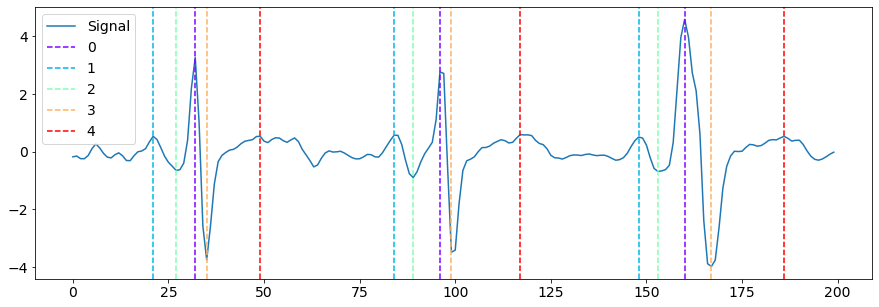

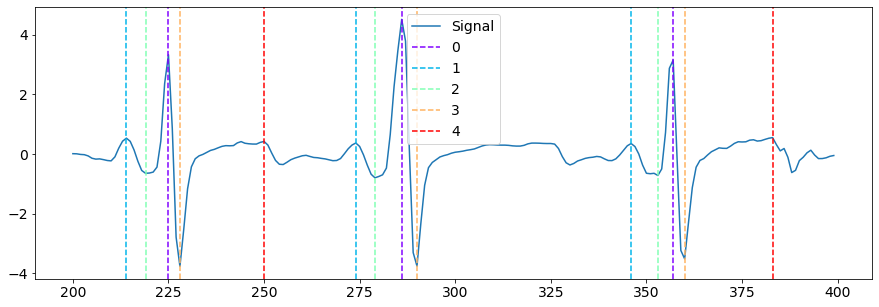

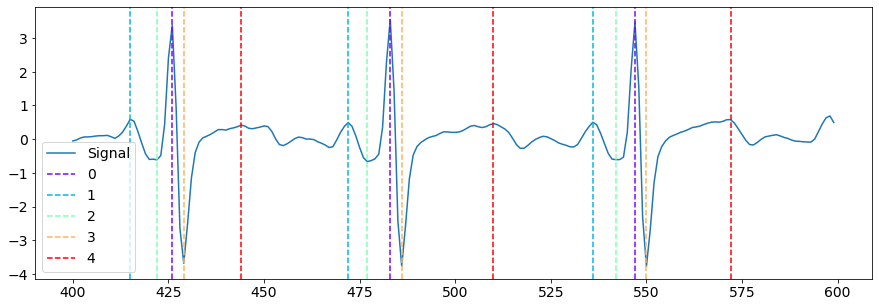

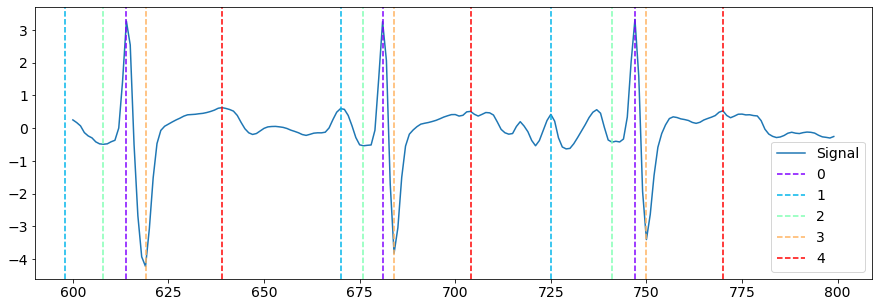

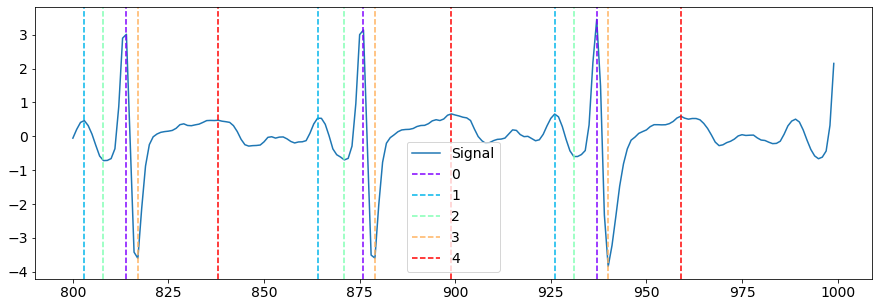

Please input the number of R peak hits 15
Please input the number of R peak false positives 0
Please input the number of R peak misses 0


str

1.0 1.0 1.0
Please input the number of P peak hits 14
Please input the number of P peak false positives 1
Please input the number of P peak misses 1


str

0.9333333333333333 0.9333333333333333 0.9333333333333333
Please input the number of Q peak hits 4
Please input the number of Q peak false positives 10
Please input the number of Q peak misses 10


str

0.2857142857142857 0.2857142857142857 0.2857142857142857
Please input the number of S peak hits 15
Please input the number of S peak false positives 0
Please input the number of S peak misses 0


str

1.0 1.0 1.0
Please input the number of T peak hits 14
Please input the number of T peak false positives 0
Please input the number of T peak misses 1


str

1.0 0.9333333333333333 0.9655172413793104


In [35]:
# from matplotlib.pyplot import plot, show
#def ECGperformance(ECG,samplerate):
samplerate = 100
data_on = chunks_on_dict['VP20']
data_part_on = data_on[data_on['Label'] == str(16)]
# this appears to need re-indexing to get the peaks to line up with the signal
ECG_on = data_part_on['ECG'].iloc[0:1000]

ECG_on.reset_index(drop=True,inplace=True)
#display(ECG_on)
#plt.plot(ECG_on)
info = nk.ecg_findpeaks(ECG_on, sampling_rate=100, method="neurokit")
#display(type(ECG_on))
#display(info)

if len(info) > 0:
        # Identify the smaller parts of the waveform; "show" command produces plot of each waveform on top of the others
        # waves_peak contains the sample stamp for the smaller parts of the waveform
        _, waves_peak = nk.ecg_delineate(ECG_on, sampling_rate=100,show=False)#, show_type='peaks')
        Rpeak_feats = nk.hrv(info['ECG_R_Peaks'],samplerate)
        display(type(waves_peak['ECG_P_Peaks']))
        #display(waves_peak)
        # need to remove nan values from waves_peak
        clean_waves = {k: [x for x in waves_peak[k] if not np.isnan(x)] for k in waves_peak}
        #display(clean_waves)
        
        # Plot the full waveform with each peak marked
        plt.figure(figsize=(50,30))
        plot = nk.events_plot([info['ECG_R_Peaks'][:3],
                              waves_peak['ECG_P_Peaks'][:3],
                              waves_peak['ECG_Q_Peaks'][:3],
                              waves_peak['ECG_S_Peaks'][:3],
                              waves_peak['ECG_T_Peaks'][:3]], ECG_on[0:200])
        plot = nk.events_plot([info['ECG_R_Peaks'][3:6],
                              waves_peak['ECG_P_Peaks'][3:6],
                              waves_peak['ECG_Q_Peaks'][3:6],
                              waves_peak['ECG_S_Peaks'][3:6],
                              waves_peak['ECG_T_Peaks'][3:6]], ECG_on[200:400])
        plot = nk.events_plot([info['ECG_R_Peaks'][6:9],
                              waves_peak['ECG_P_Peaks'][6:9],
                              waves_peak['ECG_Q_Peaks'][6:9],
                              waves_peak['ECG_S_Peaks'][6:9],
                              waves_peak['ECG_T_Peaks'][6:9]], ECG_on[400:600])
        plot = nk.events_plot([info['ECG_R_Peaks'][9:12],
                              waves_peak['ECG_P_Peaks'][9:12],
                              waves_peak['ECG_Q_Peaks'][9:12],
                              waves_peak['ECG_S_Peaks'][9:12],
                              waves_peak['ECG_T_Peaks'][9:12]], ECG_on[600:800])
        plot = nk.events_plot([info['ECG_R_Peaks'][12:15],
                              waves_peak['ECG_P_Peaks'][12:15],
                              waves_peak['ECG_Q_Peaks'][12:15],
                              waves_peak['ECG_S_Peaks'][12:15],
                              waves_peak['ECG_T_Peaks'][12:15]], ECG_on[800:1000])
        plt.show()

else:
    info = float("NaN")
    print('Could not detect R peaks')

tp_R = input("Please input the number of R peak hits ")
fp_R = input("Please input the number of R peak false positives ")
fn_R = input("Please input the number of R peak misses ")

display(type(tp_R))
precision_R = int(tp_R)/(int(tp_R) + int(fp_R))
recall_R = int(tp_R)/(int(tp_R) + int(fn_R))
#F1_R = 2/(recall_R + (1/precision_R))
F1_R = 2*((precision_R*recall_R)/(precision_R+recall_R))
print(precision_R, recall_R, F1_R)

tp_P = input("Please input the number of P peak hits ")
fp_P = input("Please input the number of P peak false positives ")
fn_P = input("Please input the number of P peak misses ")

display(type(tp_P))
precision_P = int(tp_P)/(int(tp_P) + int(fp_P))
recall_P = int(tp_P)/(int(tp_P) + int(fn_P))
# F1_P = 2/(recall_P + (1/precision_P))
F1_P = 2*((precision_P*recall_P)/(precision_P+recall_P))

print(precision_P, recall_P, F1_P)

tp_Q = input("Please input the number of Q peak hits ")
fp_Q = input("Please input the number of Q peak false positives ")
fn_Q = input("Please input the number of Q peak misses ")

display(type(tp_Q))
precision_Q = int(tp_Q)/(int(tp_Q) + int(fp_Q))
recall_Q = int(tp_Q)/(int(tp_Q) + int(fn_Q))
#F1_Q = 2/(recall_Q + (1/precision_Q))
F1_Q = 2*((precision_Q*recall_Q)/(precision_Q+recall_Q))
print(precision_Q, recall_Q, F1_Q)

tp_S = input("Please input the number of S peak hits ")
fp_S = input("Please input the number of S peak false positives ")
fn_S = input("Please input the number of S peak misses ")

display(type(tp_S))
precision_S = int(tp_S)/(int(tp_S) + int(fp_S))
recall_S = int(tp_S)/(int(tp_S) + int(fn_S))
#F1_S = 2/(recall_S + (1/precision_S))
F1_S = 2*((precision_S*recall_S)/(precision_S+recall_S))
print(precision_S, recall_S, F1_S)

tp_T = input("Please input the number of T peak hits ")
fp_T = input("Please input the number of T peak false positives ")
fn_T = input("Please input the number of T peak misses ")

display(type(tp_T))
precision_T = int(tp_T)/(int(tp_T) + int(fp_T))
recall_T = int(tp_T)/(int(tp_T) + int(fn_T))
#F1_T = 2/(recall_T + (1/precision_T))
F1_T = 2*((precision_T*recall_T)/(precision_T+recall_T))
print(precision_T, recall_T, F1_T)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<class 'list'>


C:\Users\Katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'recall')

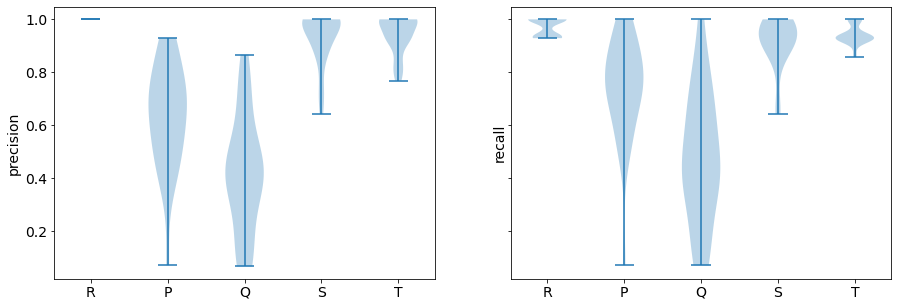

In [74]:
# Performance plotting
R_precision_1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.917, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
R_recall_1 = [1, 1, 0.917, 0.917, 1, 1, 1, 0.923, 0.917, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.917, 0.917, 0.909, 1, 1, 1, 0.917, 1,
              1, 1, 0.857, 1, 1]
P_precision_1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
P_recall_1 = [1, 1, 0.917, 0.917, 1, 0.917, 1, 1, 0.917, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.917, 0.917, 1, 0.909, 0.917, 0.923, 
              1, 0.917, 1, 0.917, 1, 0.857, 1, 0.917]
Q_precision_1 = [0.818, 0.333, 0.545, 0.273, 0.417, 0.091, 0.364, 0.25, 0.364, 0.182, 0.083, 0.4, 0.818, 0.909, 1, 0.909, 1, 0.545,
               1, 0.182, 1, 0.5, 0.909, 0.25, 1, 0.182, 0.182, 0.455, 0.909, 0.333, 0.5, 0.083]
Q_recall_1 = [0.818, 0.333, 0.5, 0.25, 0.417, 0.083, 0.364, 0.25, 0.333, 0.182, 0.083, 0.4, 0.818, 0.909, 1, 0.909, 1, 0.545, 1,
              0.167, 0.917, 0.455, 0.833, 0.231, 1, 0.167, 0.182, 0.455, 0.909, 0.286, 0.5, 0.077]
S_precision_1 = [1, 1, 1, 1, 1, 1, 1, 0.909, 1, 1, 0.917, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
S_recall_1 = [1, 0.917, 0.9, 1, 1, 1, 1, 0.909, 0.917, 1, 0.846, 1, 1, 1, 1, 1, 1, 0.909, 1, 1, 0.917, 0.909, 1, 1, 0.917, 0.917,
              1, 1, 1, 0.923, 1, 1]
T_precision_1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
T_recall_1 = [1, 1, 0.9, 1, 1, 1, 1, 0.923, 0.917, 1, 0.917, 1, 1, 1, 1, 1, 1, 1, 0.917, 0.917, 0.909, 0.909, 1, 0.923, 0.917,
              0.909, 1, 0.917, 0.917, 0.923, 1, 0.917]

R_precision = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
R_recall = [1, 1, 1, 0.929, 1, 0.933, 1, 0.933, 1, 0.933, 0.933, 0.933, 1, 1, 1, 1, 0.938, 0.929, 0.933, 1, 0.938, 0.938, 1, 
            0.933, 1, 0.929, 1, 1, 1, 1, 1, 0.933]
P_precision = [0.857, 0.923, 0.813, 0.545, 0.467, 0.643, 0.571, 0.923, 0.429, 0.692, 0.769, 0.429, 0.308, 0.071, 0.539, 0.571,
               0.643, 0.417, 0.714, 0.733, 0.667, 0.533, 0.714, 0.786, 0.533, 0.4, 0.692, 0.714, 0.786, 0.857, 0.929, 0.615]
P_recall = [0.923, 0.8, 1, 0.5, 0.875, 0.75, 0.8, 0.923, 0.857, 1, 1, 0.75, 0.667, 0.071, 0.538, 0.571, 0.6, 0.455, 0.667, 0.846,
            0.833, 0.667, 0.714, 0.733, 0.727, 0.571, 0.75, 0.769, 0.846, 0.857, 0.929, 0.727]
Q_precision = [0.467, 0.154, 0.437, 0.308, 0.133, 0.067, 0.438, 0.143, 0.357, 0.786, 0.429, 0.357, 0.533, 0.786, 0.429, 0.643,
               0.538, 0.385, 0.571, 0.385, 0.467, 0.867, 0.286, 0.429, 0.688, 0.182, 0.308, 0.462, 0.071, 0.429, 0.067, 0.714]
Q_recall = [1, 0.143, 0.438, 0.5, 0.286, 0.125, 0.7, 0.167, 0.714, 0.846, 0.6, 0.357, 0.571, 0.786, 0.429, 0.643, 0.5, 0.357,
            0.571, 0.385, 0.412, 0.867, 0.308, 0.4, 0.688, 0.2, 0.4, 0.545, 0.077, 0.429, 0.071, 0.714]
S_precision = [1, 1, 0.938, 0.692, 0.867, 1, 0.938, 0.929, 0.929, 0.727, 0.769, 0.929, 0.867, 0.643, 1, 1, 0.933, 1, 1, 0.857, 1,
               0.933, 1, 1, 0.875, 1, 1, 1, 1, 1, 1, 1]
S_recall = [1, 0.929, 0.938, 0.643, 1, 0.933, 1, 0.929, 1, 0.8, 0.714, 0.867, 0.867, 0.643, 1, 0.933, 0.875, 0.929, 0.933, 0.857,
            0.938, 0.875, 1, 0.933, 0.875, 1, 1, 1, 0.933, 0.933, 1, 0.933]
T_precision = [0.8, 1, 0.8, 0.846, 0.933, 1, 0.857, 1, 0.929, 0.923, 1, 1, 0.933, 0.929, 0.929, 1, 0.933, 0.923, 1, 0.769, 0.933,
               0.938, 1, 1, 0.813, 1, 1, 1, 1, 1, 1, 1]
T_recall = [1, 0.929, 0.857, 0.917, 1, 0.933, 0.923, 0.929, 0.929, 0.923, 0.933, 0.933, 1, 0.867, 0.929, 0.933, 0.933, 0.923, 
            0.933, 1, 0.933, 0.938, 1, 0.933, 0.929, 1, 1, 0.923, 0.933, 0.933, 1, 0.933]



data_precision = [R_precision, P_precision, Q_precision, S_precision, T_precision]
data_recall = [R_recall, P_recall, Q_recall, S_recall, T_recall]

print(R_precision)

print(type(data_precision))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
parts = ax1.violinplot(data_precision)
# for pc in parts['bodies']:
#     pc.set_facecolor('#D43F3A')
#     pc.set_edgecolor('black')
#     pc.set_alpha(1)

labels = ['','R','P','Q','S','T']
ax1.set_xticklabels(labels)
ax1.set_ylabel('precision')
ax2.violinplot(data_recall)
ax2.set_xticklabels(labels)
ax2.set_ylabel('recall')




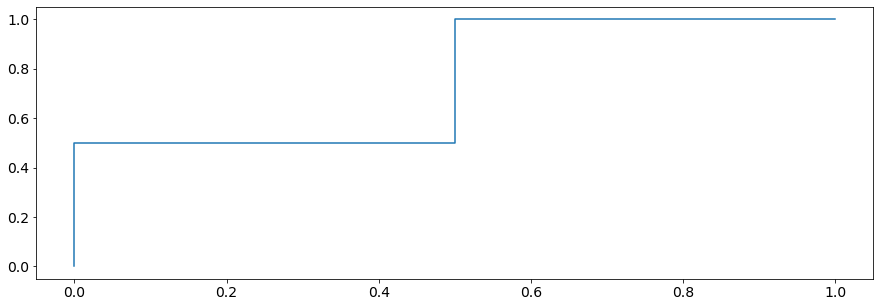

In [273]:
# ROC curves
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_true = np.array([1, 1, 2, 2])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores,pos_label=2)
plt.plot(fpr,tpr)

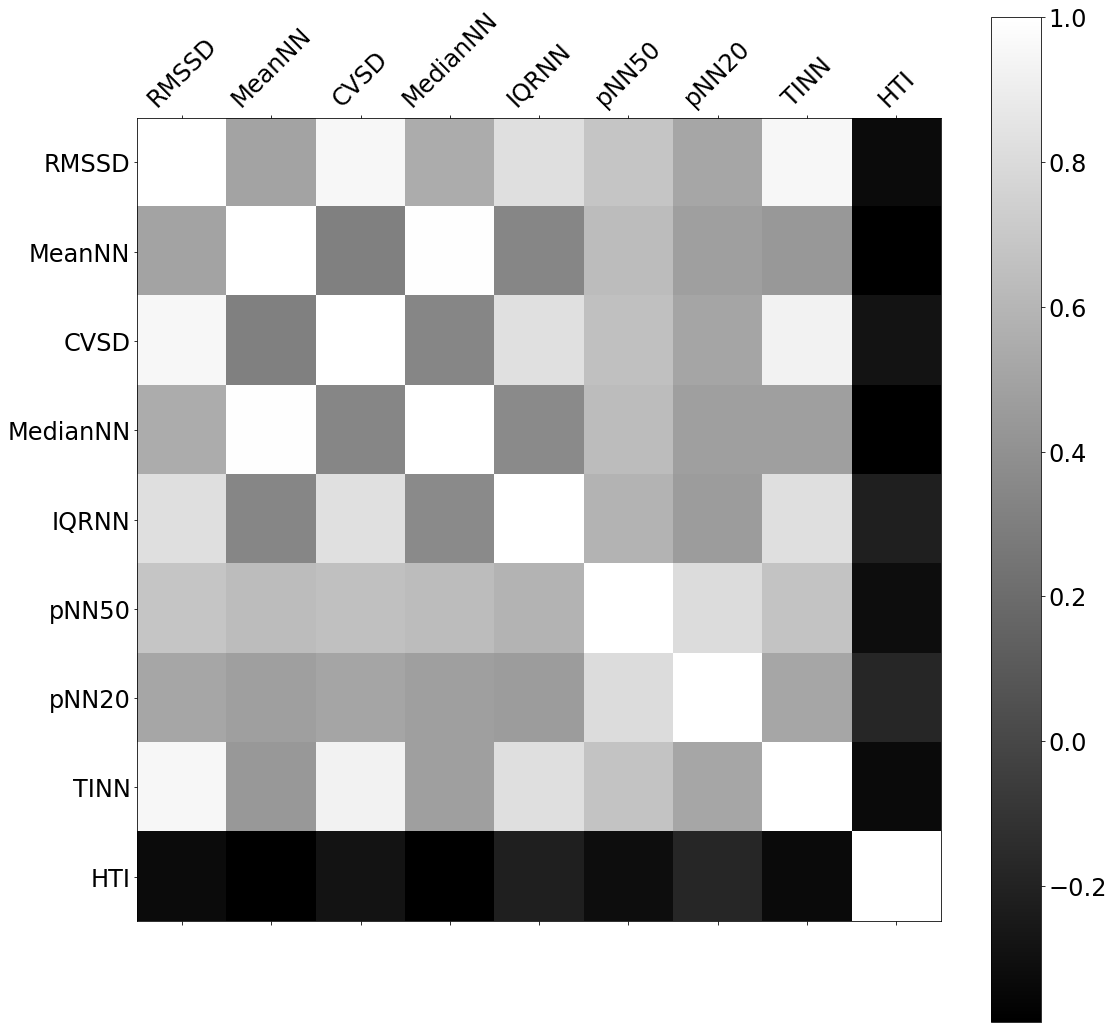

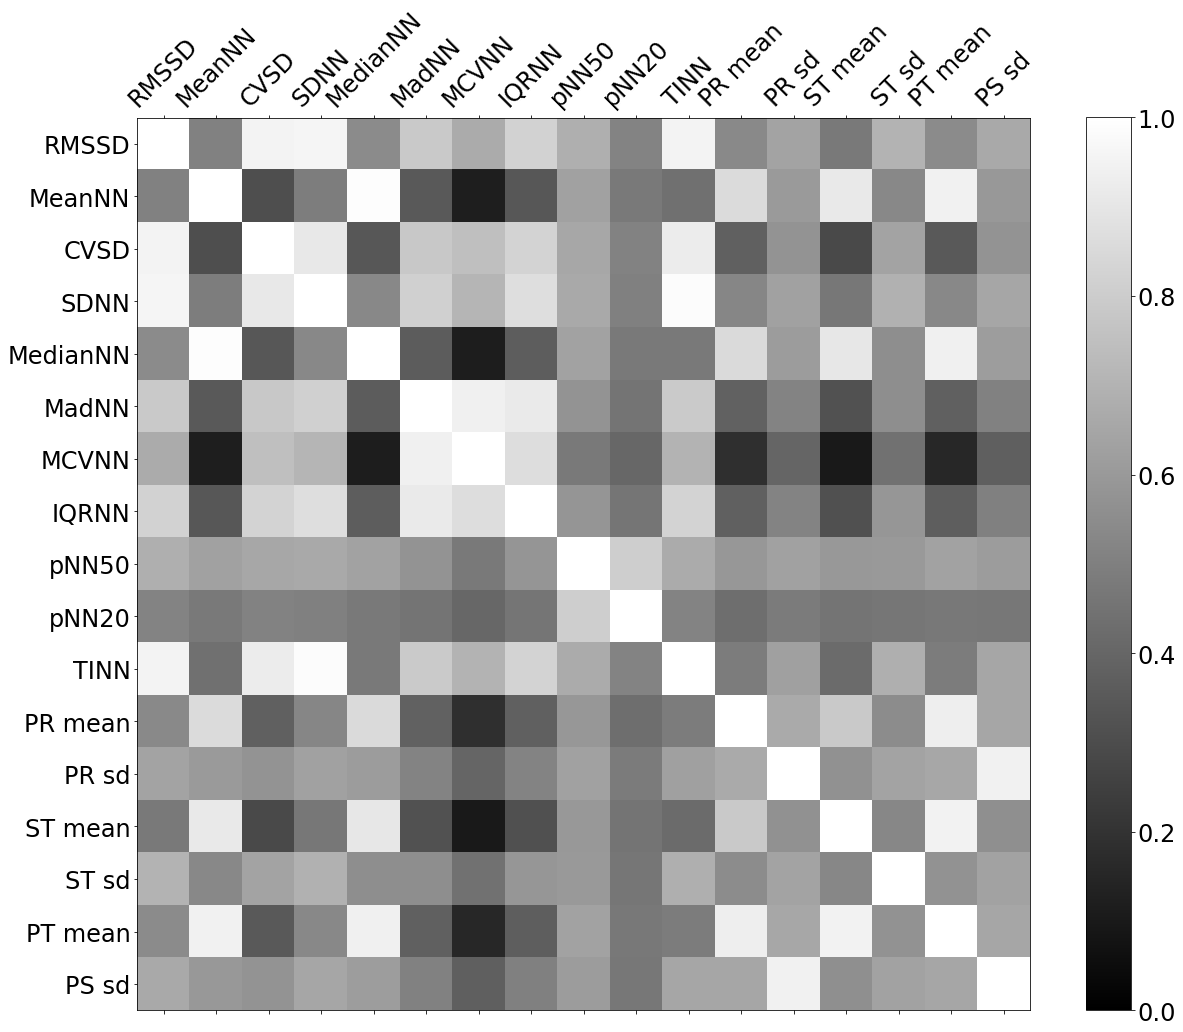

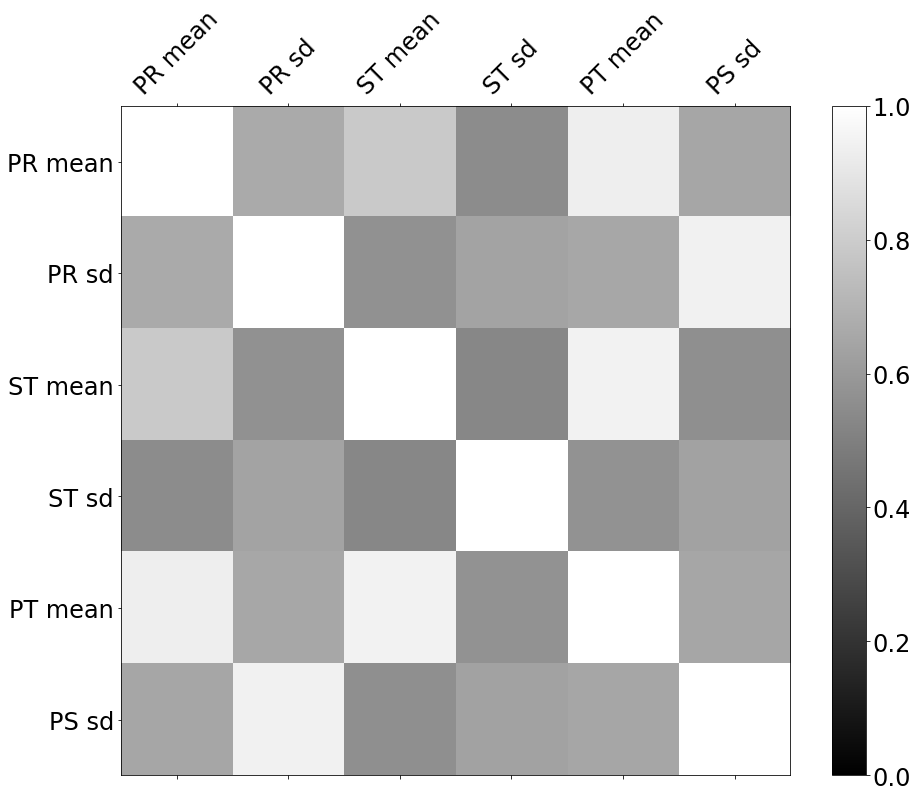

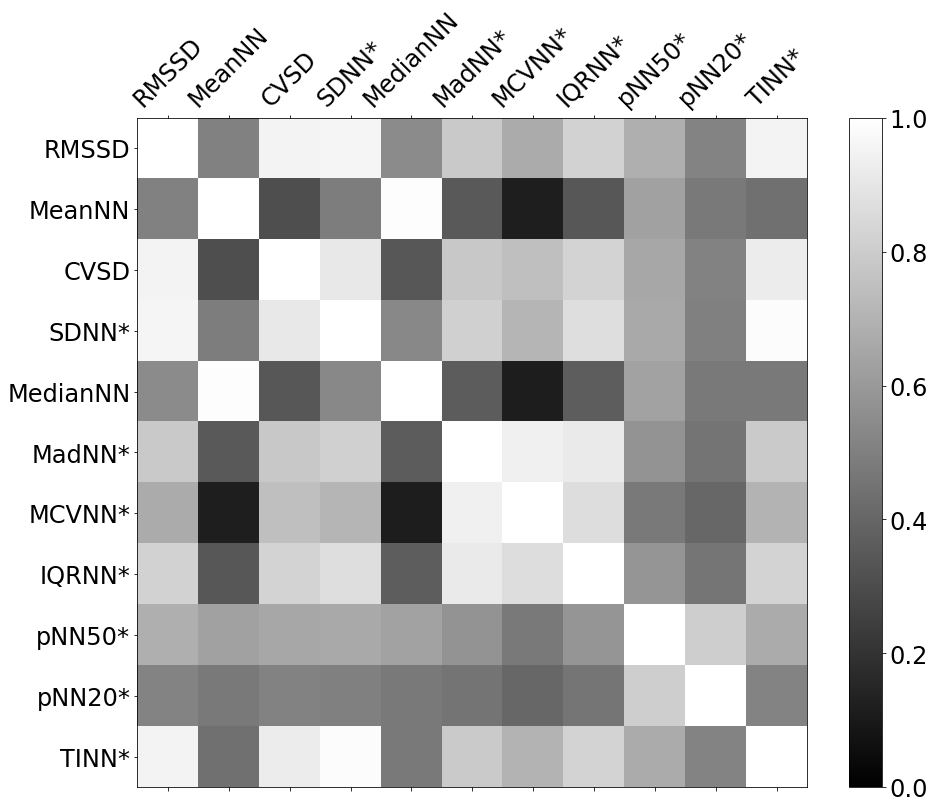

In [46]:
# Figures for paper
# correlation matrix for optimized traditional model
trad_data = data[['HRV_RMSSD', 'HRV_MeanNN', 'HRV_CVSD','HRV_MedianNN','HRV_IQRNN','HRV_pNN50','HRV_pNN20',
                  'HRV_TINN','HRV_HTI']].copy()
trad_names = ['RMSSD', 'MeanNN', 'CVSD','MedianNN','IQRNN','pNN50','pNN20',
                  'TINN','HTI']
fig = plt.figure(figsize=(18,18))
plt.matshow(trad_data.corr(method='pearson'),fignum=fig.number, cmap='gray')
plt.xticks(range(trad_data.shape[1]), trad_names, fontsize=24, rotation=45)
plt.yticks(range(trad_data.shape[1]), trad_names, fontsize=24)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=24)
plt.show()
fig.savefig('TFMcorrmat_100dpi.png', dpi=100)

# correlation matrix for optimized novel model
nov_data = data[['HRV_RMSSD', 'HRV_MeanNN', 'HRV_CVSD','HRV_SDNN', 'HRV_MedianNN', 
                 'HRV_MadNN', 'HRV_MCVNN','HRV_IQRNN','HRV_pNN50','HRV_pNN20',
                  'HRV_TINN','PR_mean','PR_sd','ST_mean','ST_sd','PT_mean','PS_sd']].copy()
nov_names = ['RMSSD','MeanNN','CVSD','SDNN', 'MedianNN', 'MadNN', 'MCVNN','IQRNN','pNN50','pNN20',
                  'TINN','PR mean','PR sd','ST mean','ST sd','PT mean','PS sd']
fig = plt.figure(figsize=(20,20))
plt.matshow(nov_data.corr(method='pearson'),fignum=fig.number,cmap='gray')
plt.xticks(range(nov_data.shape[1]), nov_names, fontsize=24, rotation=45)
plt.yticks(range(nov_data.shape[1]), nov_names, fontsize=24)
cb = plt.colorbar(shrink=0.8)
plt.clim(0,1.0)
cb.ax.tick_params(labelsize=24)
plt.show()
fig.savefig('allfeatscorrmat_300dpi.png', dpi=300)

# just the small peak features
nov_data = data[['PR_mean','PR_sd','ST_mean','ST_sd','PT_mean','PS_sd']].copy()
nov_names = ['PR mean','PR sd','ST mean','ST sd','PT mean','PS sd']

fig = plt.figure(figsize=(15,15))
plt.matshow(nov_data.corr(method='pearson'),fignum=fig.number,cmap='gray')
plt.xticks(range(nov_data.shape[1]), nov_names, fontsize=24, rotation=45)
plt.yticks(range(nov_data.shape[1]), nov_names, fontsize=24)
plt.clim(0,1.0)
cb = plt.colorbar(shrink=0.8)
cb.ax.tick_params(labelsize=24)
plt.show()
fig.savefig('smallpeakcorrmat_300dpi.png', dpi=300)

# just the R peak features
nov_data = data[['HRV_RMSSD', 'HRV_MeanNN', 'HRV_CVSD','HRV_SDNN', 'HRV_MedianNN', 
                 'HRV_MadNN', 'HRV_MCVNN','HRV_IQRNN','HRV_pNN50','HRV_pNN20',
                  'HRV_TINN']].copy()
nov_names = ['RMSSD','MeanNN','CVSD','SDNN*', 'MedianNN', 'MadNN*', 'MCVNN*','IQRNN*','pNN50*','pNN20*',
                  'TINN*']

fig = plt.figure(figsize=(15,15))
plt.matshow(nov_data.corr(method='pearson'),fignum=fig.number,cmap='gray')
plt.xticks(range(nov_data.shape[1]), nov_names, fontsize=24, rotation=45)
plt.yticks(range(nov_data.shape[1]), nov_names, fontsize=24)
cb = plt.colorbar(shrink=0.8)
plt.clim(0,1.0)
cb.ax.tick_params(labelsize=24)
plt.show()
fig.savefig('Rpeakcorrmat_300dpi.png', dpi=300)

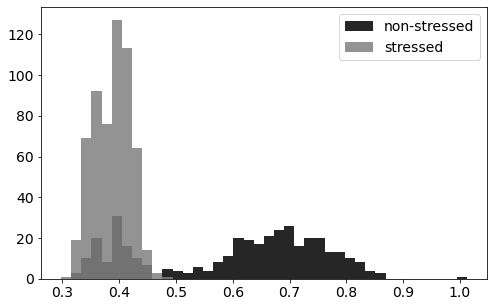

In [21]:
non_stress = justHRfeats[justHRfeats.stress==0]
stressed = justHRfeats[justHRfeats.stress==1]

fig = plt.figure(figsize=(8,5))

_,bins = np.histogram(justHRfeats['PT_mean'],bins=40)
plt.hist(non_stress['PT_mean'],bins=bins,color='black',alpha=.85)
plt.hist(stressed['PT_mean'],bins=bins,color='grey',alpha=.85)
#plt.set_title('RMSSD')
plt.legend(['non-stressed','stressed'],loc='best',fontsize=14)


plt.show()
fig.savefig("PTmean_hipbc_hist_100dpi_new.png",dpi=100)

C:\Users\Katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: UserWarning: FixedFormatter should only be used together with FixedLocator


0.8604216815125 0.2541918119633979


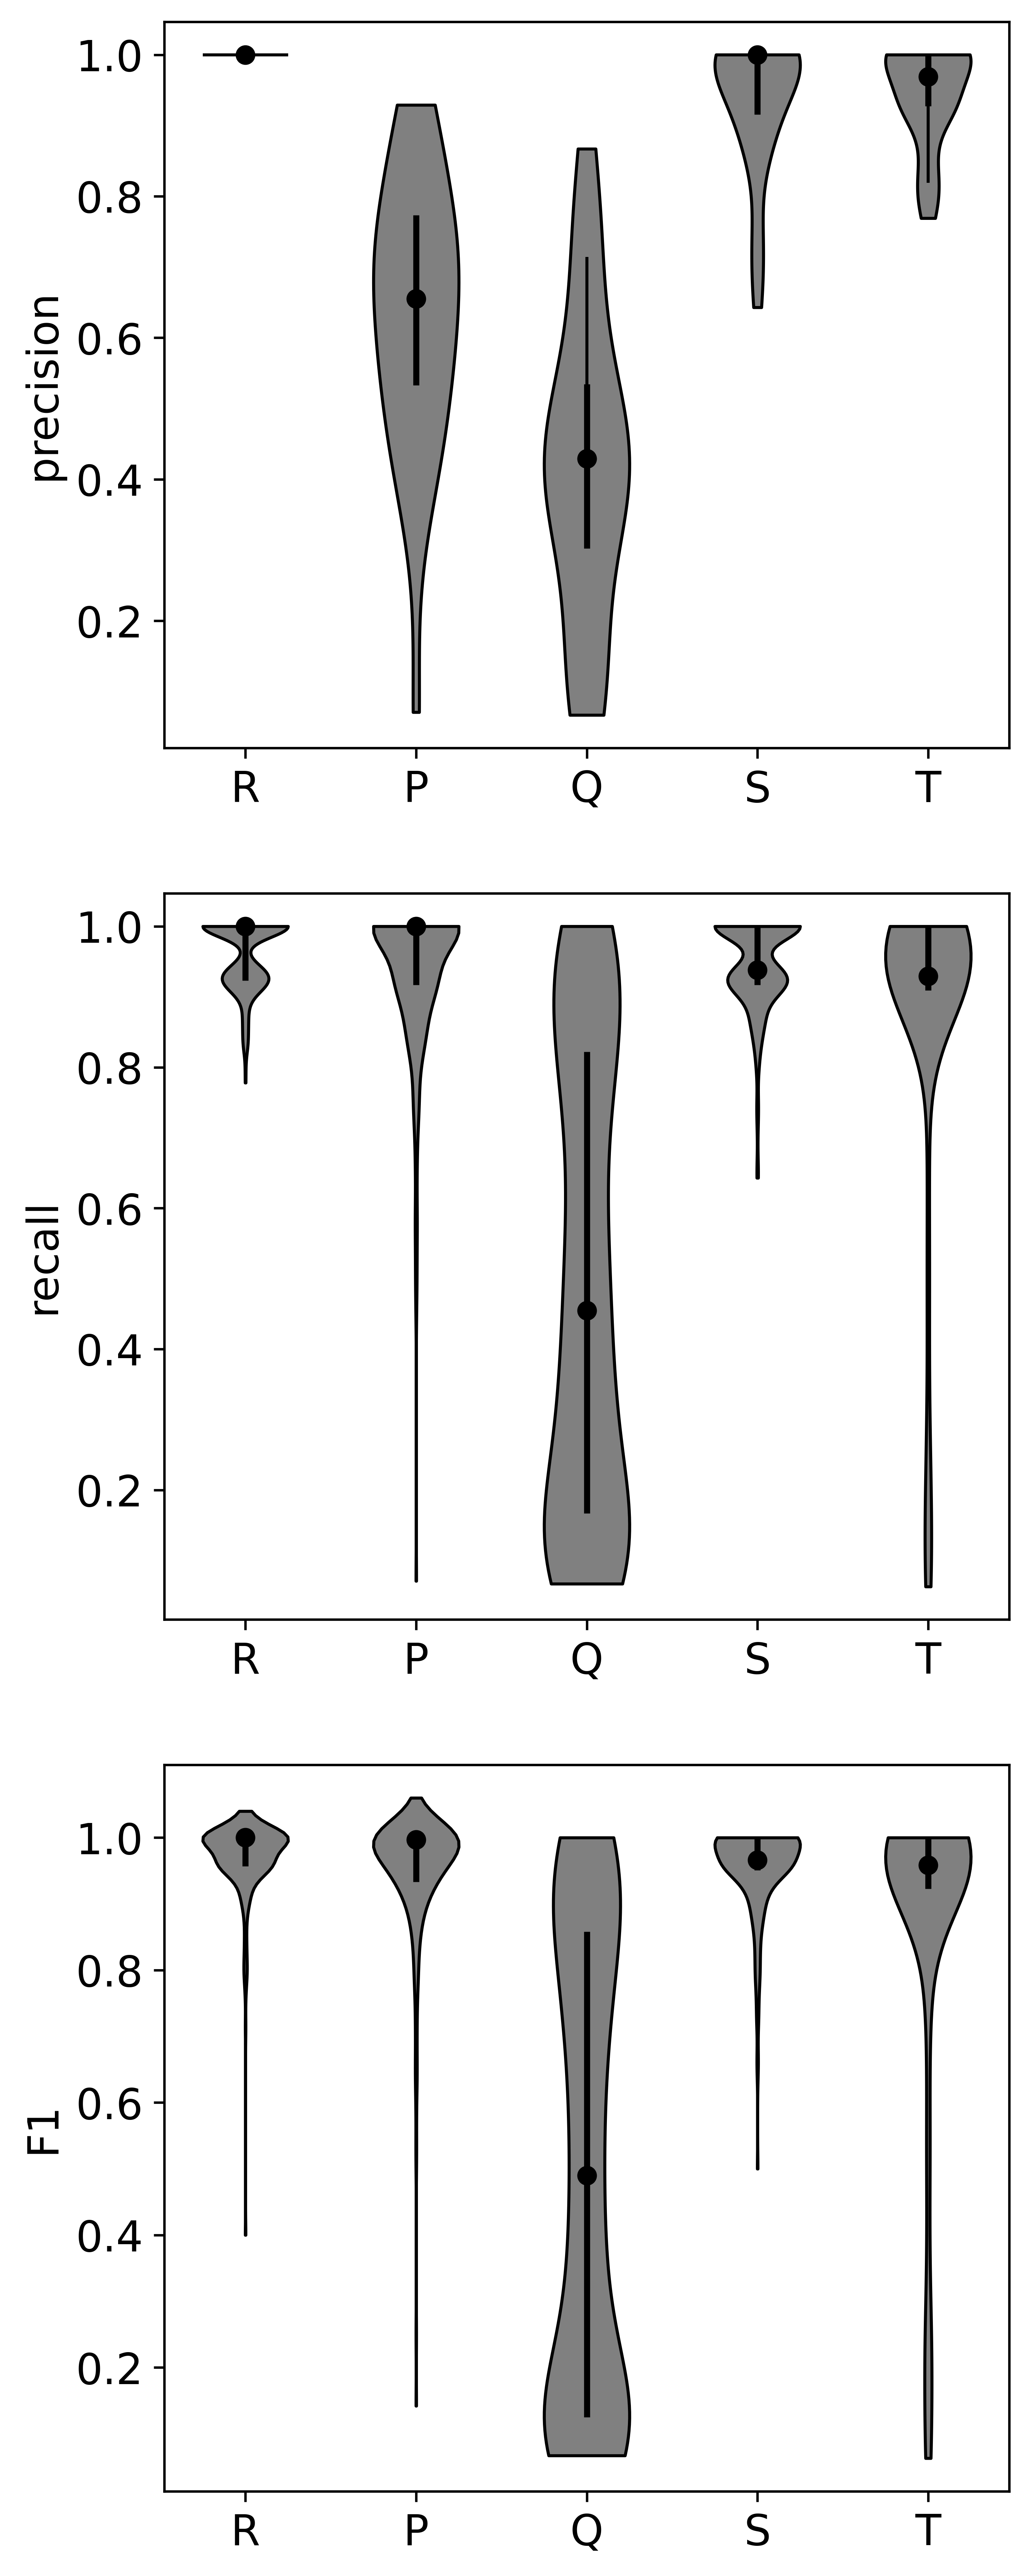

In [150]:
# Read in performance data
import statistics as st
perf = pd.read_csv('spider_fear/performance_10subs.csv', names = ['sub','stress','sample','Rprecision','Rrecall','RF1',
                                                         'Pprecision', 'Precall', 'PF1', 'Qprecision','Qrecall',
                                                         'QF1', 'Sprecision', 'Srecall', 'SF1', 'Tprecision', 'Trecall',
                                                         'TF1'], engine='python')
newRprec = perf['Rprecision'].tolist()
newRprec = [float(i) for i in newRprec[1:321]] 

newPprec = perf['Pprecision'].tolist()
newPprec = [float(i) for i in newPprec[1:321]] 

newQprec = perf['Qprecision'].tolist()
newQprec = [float(i) for i in newQprec[1:321]] 

newSprec = perf['Sprecision'].tolist()
newSprec = [float(i) for i in newSprec[1:321]] 

newTprec = perf['Tprecision'].tolist()
newTprec = [float(i) for i in newTprec[1:321]] 

newRrec = perf['Rrecall'].tolist()
newRrec = [float(i) for i in newRrec[1:321]] 

newPrec = perf['Precall'].tolist()
newPrec = [float(i) for i in newPrec[1:321]] 

newQrec = perf['Qrecall'].tolist()
newQrec = [float(i) for i in newQrec[1:321]] 

newSrec = perf['Srecall'].tolist()
newSrec = [float(i) for i in newSrec[1:321]] 

newTrec = perf['Trecall'].tolist()
newTrec = [float(i) for i in newTrec[1:321]] 

newRF1 = perf['RF1'].tolist()
newRF1 = [float(i) for i in newRF1[1:321]] 

newPF1 = perf['PF1'].tolist()
newPF1 = [float(i) for i in newPF1[1:321]] 

newQF1 = perf['QF1'].tolist()
newQF1 = [float(i) for i in newQF1[1:321]] 

newSF1 = perf['SF1'].tolist()
newSF1 = [float(i) for i in newSF1[1:321]] 

newTF1 = perf['TF1'].tolist()
newTF1 = [float(i) for i in newTF1[1:321]] 

data_precision = [newRprec[32:64], newPprec[32:64], newQprec[32:64], newSprec[32:64], newTprec[32:64]]
data_recall = [newRrec, newPrec, newQrec, newSrec, newTrec]
dataF1 = [newRF1, newPF1, newQF1, newSF1, newTF1]


labels = ['','R','P','Q','S','T']
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

# Create the figure
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(5,15), sharey=False, dpi=600)



# Plot distributions of precision
parts1 = ax1.violinplot(data_precision, showmeans=False, showmedians=False, showextrema=False)
ax1.set_xticklabels(labels)
ax1.set_ylabel('precision')

for pc in parts1['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(data_precision, [25, 50, 75], axis=1)
whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(data_precision, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax1.scatter(inds, medians, marker='o', color='black', s=30, zorder=3)
ax1.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2)
ax1.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)


# Plot distributions of recall
ax2.set_xticklabels(labels)
ax2.set_ylabel('recall')


parts2 = ax2.violinplot(data_recall, showmeans=False, showmedians=False, showextrema=False)

for pc in parts2['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(data_recall, [25, 50, 75], axis=1)
whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(data_recall, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='black', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2)
ax2.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

# Plot distributions of F1 metric
ax3.set_xticklabels(labels)
ax3.set_ylabel('F1')


parts3 = ax3.violinplot(dataF1, showmeans=False, showmedians=False, showextrema=False)

for pc in parts3['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(dataF1, [25, 50, 75], axis=1)
whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(dataF1, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax3.scatter(inds, medians, marker='o', color='black', s=30, zorder=3)
ax3.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2)
ax3.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

print(st.mean(newTF1),st.stdev(newTF1))
plt.savefig("peakdetect_100dpi.png",dpi=100)